# Palmer LTER Inorganic Analysis
Antarctica's Western Penninsula is a rapidly changing ecosystem. To quantify these changes and prepare for the Global biogeochemical and ecological costs of these changes, we must look at long terms trends. Here is analysis of 15 years of data taken from Palmer LTER January cruises. The Cruise follows a regional grid along the Western Antarctica Penninsula (WAP) as follows:

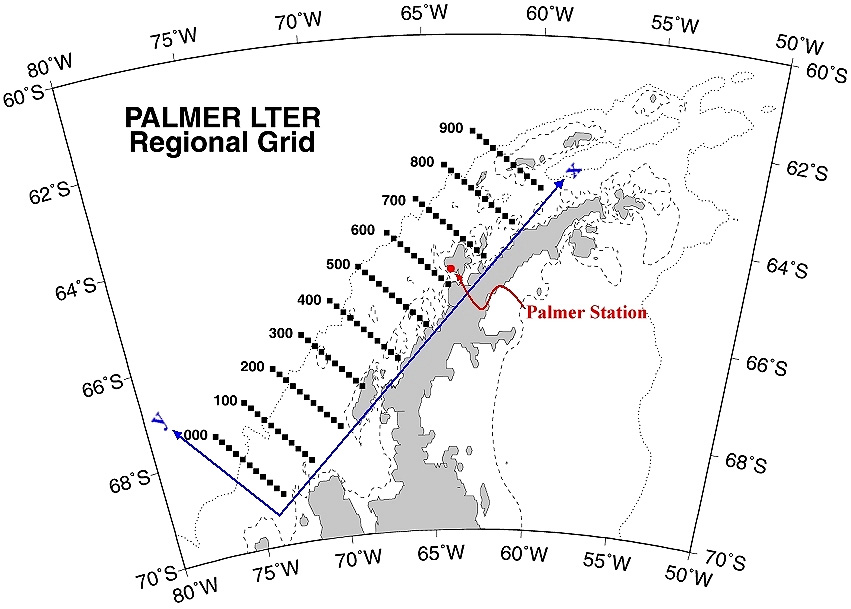

In [99]:
Image(filename='palmerGrid.jpg') 

The software in this notebook is intended to help standardize data to expedite analysis and high-quality research. Specifically, this iPython notebook transfers the Palmer Inorganic Nutrient dataset into a <a target="_blank" href='http://pandas.pydata.org/pandas-docs/stable/tutorials.html'>Pandas</a> dataframe, cleans and standardizes measurements according to a simplified grid, provides depth profiles for per nutrient per station per year, and interpolates station data between and throughout years to get a glimpse of reigonal inorganic nutrient patterns. CTD data is also used to estimate <b>Mixed Layer Depth (MLD)</b> using a gradient and threshold method. The combined NO<sub>2</sub> NO<sub>3</sub> is integrated from the surface to the MLD for each station annually to quantify the nutrients removed from the water column due to Phytoplankton and Diatoms. From there, we can employ the stoichiometric ratio of marine biota-- known as the Redfield Ratio, to calculate how much CO<sub>2</sub> is taken from the water column from this process called, <b>Net Primary Production</b> (NPP).
<br>
All files necessary to run this notebook can be found in the <a target="_blank" href='https://github.com/yinleon/palmer'>github repo</a>, all data was downloaded from UCSD's <a target="_blank" href='http://oceaninformatics.ucsd.edu/datazoo/data/pallter/datasets'>Datazoo</a>, additional inromation is avaiable from <a target="_blank" href='http://pal.lternet.edu/'>Palmer LTER</a>.
<br><br>This Notebook is intended to be downloaded and run on your personal machine OR viewed from <a target="_blank" href='http://nbviewer.jupyter.org/github/yinleon/Palmer/blob/master/palmerInOrg.ipynb'>Jupyter's nbviewer</a>, because of this the indexing links from the table of contents will not work on github! 
<br><br>Last edited 12.29.15 by <a target="_blank" href='https://yinleon.github.io'>Leon Yin</a>.
<br><br><b>Acknowledgements</b>
<br>I want to thank Hugh Ducklow and Ryan Abernathey for their expert guidance.

# Table of Contents <a id='h'>
<header>Data Prossessing: How can we can compare ship-board measurements?</header>
<a href='#standard'>Standardizing the Database</a><br>
<a href='#save'>Saving the Clean Database</a><br>
<header>Biogeochemistry: How do intorganic nutrients vary with depth and breadth?</header>
<a href='#profiles'>Interannual Nutrient Profiles</a><br>
<a href='#inter'>Interannual Surface Interpolation Algorithm</a><br>
<a href='#interA'>Average Surface Interpolation Algorithm</a><br>
<a href='#interNitrite'>Interannual Surface Interpolation NO<sub>3</sub> + NO<sub>2</sub></a><br>
<a href='#interANitrite'>Average Surface Interpolation NO<sub>3</sub> + NO<sub>2</sub></a></a><br>
<header>Physics: Using CTD data to estimate the Mixed Layer Depth.</header>
<a href='#MLD'>Estimating Mixed Layer Depth</a><br>
<a href='#MLD_coverage'>Mixed Layer Depth coverage relative to Nutrient samples</a><br>
<a href='#MLD_plot'>Interannual Mixed Layer Depth</a><br>
<header>Biogeochemistry: Using MLD and Interannual profiles to calculate Net Primary Productivity.</header>
<a href='#NPP'>Calculating Net Primary Production</a><br>

In [1]:
import pandas as pd
import numpy as np
import os
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
import colorsys
import glob
from scipy.interpolate import griddata
from IPython.display import Image
import json
from scipy.integrate import simps
from numpy import trapz
%matplotlib inline

In [2]:
# Global variables
seaborn.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (15,9)
skip          = -999                                     # skip value in thr dataset
mark          = ['o','p','d','v','s']                    # markers for scatterplots
surfDepth     = 10                                        #(m) depth of surface
maxDepth      = 250
cMap          = 'RdBu_r'
outOfGrid     = ['Trap','Rothera','B','E','notFound','outGrid']
dsPath        = 'data_sets/'                             # data set directory

Let's read the grid into Python through a Pandas dataframe, so we can work with it... Moreover, let's create some functions so we can continue to do so.

In [3]:
# Initialize the plot, functionalize it for easy recycling.
def draw_wAP(zoom=False,lat=-66.90,lon=-67.05):
    if(zoom!=1):
        map = Basemap(width=1800000,height=1000000,
                    resolution='l',projection='stere',\
                    lat_ts=50,lat_0=lat,lon_0=lon)
    elif(zoom==1):
        map = Basemap(width=320000,height=180000,
                resolution='l',projection='stere',\
                lat_ts=50,lat_0=-64.90,lon_0=-66.05)
    map.drawparallels(np.arange(-90.,90.,1.),labels=[False,False,False,True],
                      color='w',dashes=[100,.0001],zorder=0)
    map.drawmeridians(np.arange(-180.,181.,1.),labels=[True,False,False,False],
                      color='w',dashes=[100,.0001],zorder=0)
    map.drawcoastlines()
    map.fillcontinents()
    map.drawmapboundary()
    return map

In [4]:
def read_grd(fileIn,col):
    if(os.path.isfile(fileIn)):
        grid = pd.read_csv(fileIn,sep=',',skiprows=1,names=col,na_filter=True)
        grid = grid[grid.stationID.isin(outOfGrid)==False]
        return grid
    else:
        print (fileIn,"is either unreadable or DNE.")
        raise SystemExit(0)

def plt_grd(grid_df):
    map = draw_wAP(zoom=False,lat=-65.40,lon=-67.05)
    x1 = grid_df['lon'].values
    y1 = grid_df['lat'].values
    labels = grid_df['stationID']
    xS, yS = map(x1, y1)
    map.scatter(xS, yS, marker='o',s=26,color='k')

    for label, xpt, ypt in zip(labels, xS, yS):
        plt.text(xpt-70000, ypt-5000, label,size=8)
    plt.title('Palmer LTER Regional Grid')
    plt.show()

In [5]:
# files
gridInfile = os.path.join(dsPath+'Basic Western Antarctic Peninsula Survey Grid.csv')
gridCol   = ["studyName","gridLine","gridStation","stationID","lat","lon","gridCode"]

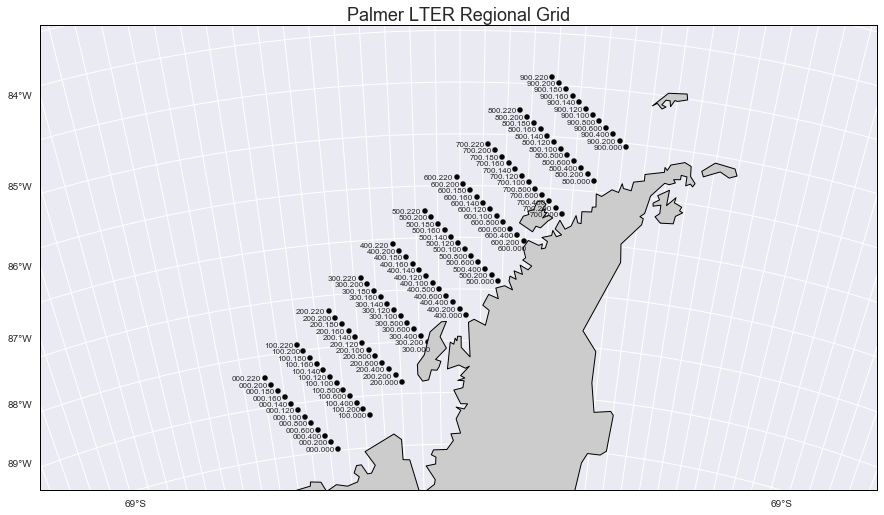

In [6]:
# first read in the grid standard
grid = read_grd(gridInfile,gridCol)
plt_grd(grid)

Sometime is not right with the station names, so let's fix it!

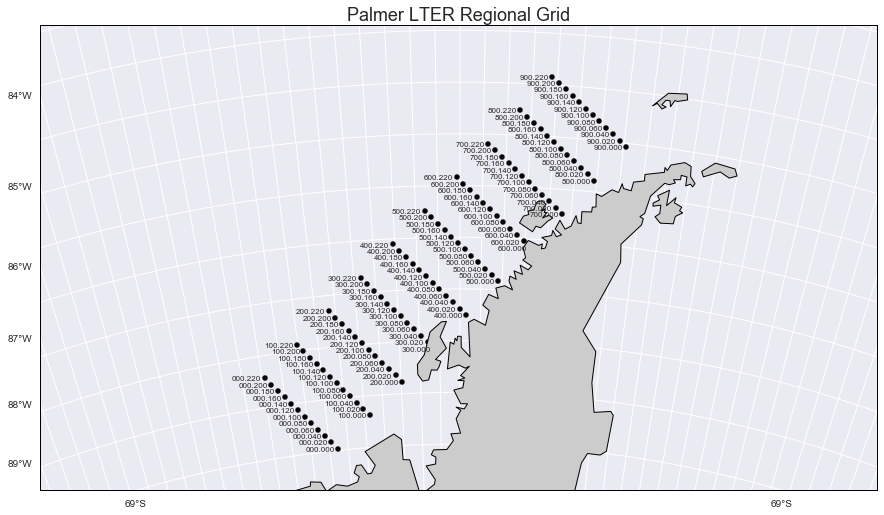

In [7]:
newGrid = read_grd(gridInfile,gridCol)
newGrid.gridStation = newGrid.gridStation.astype(int).apply(lambda x: '{0:0>3}'.format(x))
newGrid.gridLine = newGrid.gridLine.astype(int).apply(lambda x: '{0:0>3}'.format(x))
newGrid['stationID'] = newGrid.gridLine.map(str) +"."+ newGrid.gridStation.map(str)
plt_grd(newGrid)

Now let's take a look at the cruise measurements from 2000-onwards.

In [8]:
# CSV file from Datazoo
inOrgInfile = os.path.join(dsPath+'Dissolved Inorganic Nutrients.csv')

# Column formats for inorganic nutrients
inOrgCol    = ['studyName','eventNum','cast','bottle','datetime','stationID','gridLine',\
                'gridStation','lat','lon','percentIrradiance','depth','PO4','SiO4','NO2','NO3','NH4','Nitrite',\
                'notes']

def read_inOrg(infile,cols):
    # Import the files
    if(os.path.isfile(infile)):
        inOrg = pd.read_csv(infile,skiprows=1,names=cols)
        # Munging...
        inOrg = inOrg[(inOrg['lon'].notnull()) & (inOrg['lat'].notnull())&
                      (inOrg['depth']!=skip) & (inOrg['depth'].notnull())&
                      (inOrg['datetime'].notnull())]
        # Time keeping...
        inOrg =inOrg[inOrg.datetime>'1999-12-31 00:00:00'] # start date
        inOrg.datetime=pd.to_datetime(inOrg.datetime,format='%Y-%m-%d %H:%M:%S',exact=True)   
        inOrg['year']=pd.DatetimeIndex(inOrg['datetime']).year  
        inOrg['month']=pd.DatetimeIndex(inOrg['datetime']).month
        inOrg.lat=abs(inOrg.lat.map('{:,.5f}'.format).astype(float))*-1 # convert all coords to south
        inOrg.lon=abs(inOrg.lon.map('{:,.5f}'.format).astype(float))*-1 # convert all coords to west
        inOrg = inOrg.reset_index()
        print("The imported database contains",len(inOrg.index),"records.")
        return inOrg
    else:
        print (fileIn1,"is either unreadable or DNE.")
        raise SystemExit(0)
inOrg = read_inOrg(inOrgInfile,inOrgCol)

The imported database contains 9101 records.


Let's take a peep at the spatial-temporal distribution of measurments in the grid...

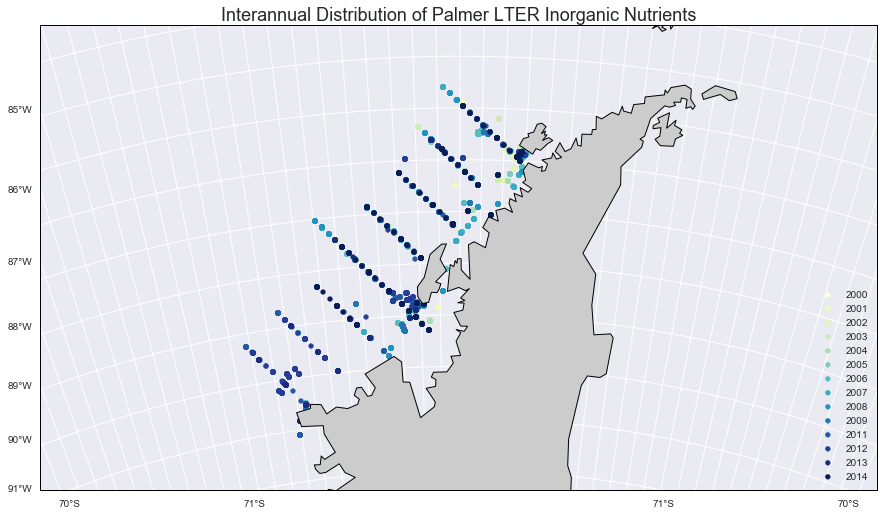

In [9]:
def plt_interannual(df,zoom=False):
    # Initialize the plot
    map = draw_wAP(zoom)
    
    yearList    = np.array(df.year.unique())                # List of years from the LTRE
    yearVar     = len(yearList)                             # How long has this been going on?
    colorSwatch = cm.YlGnBu(np.linspace(0, 1, yearVar))     # Colors for each year
    
    for i in range(yearVar):
        querry = df[df.year==yearList[i]]            # Querry the database per year
        x1 = querry.lon.values
        y1 = querry.lat.values
        x, y = map(x1, y1)                               # Convert the lat and lon to a Basemap-readable format.
        map.scatter(x, y, color=colorSwatch[i], marker='o',s=24,label=np.asarray(querry.year)[0])
    plt.legend(scatterpoints=1,
                loc='lower right',
                ncol=1,
                fontsize=10)
    plt.title('Interannual Distribution of Palmer LTER Inorganic Nutrients')
    plt.show()
plt_interannual(inOrg)

It looks like all stations are lined up with the excpetion of some outside of the station lines... But let's not make any assumptions just yet, and take a closer look.

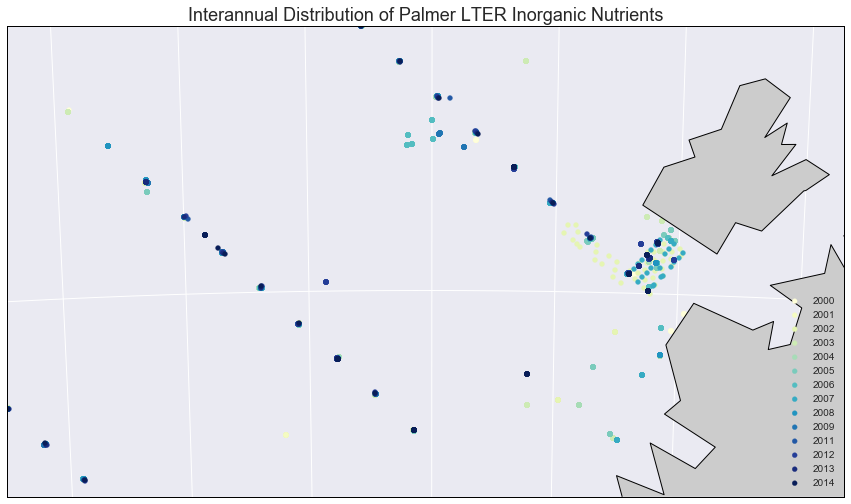

In [10]:
plt_interannual(inOrg,zoom=True)

We see that although these points are taken in the same proximity, their coordinates aren't flush to the correct percision...


In [11]:
print("We also see that there are ",len(inOrg.lat.unique()),"and",len(inOrg.lon.unique()),"unique latitude and longitude coordiantes,")
print("and that the stationID's are not standardized:\n",inOrg.stationID.unique())
print("We want to see",len(grid.stationID),"coordinate pairs and stationIDs...")

We also see that there are  903 and 940 unique latitude and longitude coordiantes,
and that the stationID's are not standardized:
 [nan '500.06' '600.04' '600.06' '600.08' '600.1' '600.12' '600.14' '600.16'
 '600.18' '600.2' '600.22' '600.26' '500.22' '500.2' '500.18' '500.16'
 '500.14' '500.12' '500.1' '500.08' '620.04' '620.035' '620.03'
 '617.5_.030' '617.5_.035' '617.5_.040' '615.04' '615.035' '615.03'
 '612.5_.030' '612.5_.035' '612.5_.040' '610.04' '610.035' '610.03'
 '607.5_.030' '607.5_.035' '607.5_.040' '605.04' '605.035' '605.03'
 '602.5_.030' '602.5_.035' '602.5_.040' '600.035' '600.03' '400.2' '400.18'
 '400.16' '400.14' '400.12' '400.1' '400.08' '400.06' '400.04' '300.04'
 '300.06' '300.08' '300.1' '300.12' '300.14' '300.16' '300.18' '300.2'
 '200.26' '200.24' '200.22' '200.2' '200.18' '200.16' '200.14' '200.12'
 '200.1' '200.08' '200.06' '200.04' '200.02' '200.-020' '200' '100'
 '100.02' '100.04' '100.06' '200.-060' '200.-040' '225.-020' '225.-025'
 '225.-030' '222.5_.-03

# Standardizing the Dataset <a id='standard'></a>
Before we can do any anaylsis, we need to wrangle the data into a comparable format... 
<br>This task can be accomplished by standizing stationIDs and coordiantes that are within reasonable bounrds of idealized station coordaintes. This function compares each gritty coordinate pair with idealized pairs and outputs a Pandas DF contianing corrected coordinates (lat,lon) and stationID.
<br><br><i>cord2stationID</i>
<br><t>Inputs:
<br><t>pandas dataframe (DF), latitude numPy array, longitue numPy array
<br><t>Outputs:
<br><t>Pandas Dataframe containing standardized lat/lon coordinates and stationID.
<br><t>ex . updatedDF = coor2stationID(df,df.lat,df.lon)
<br><a href='#h'>Top</a>

In [12]:
latThresh = 0.0645
lonThresh = 0.0750

def cord2stationID(df):
    # Lets standardize the coordinates for SW
    latIn = -1*abs(df.lat)
    lonIn = -1*abs(df.lon)

    # how many points are there?
    x=len(latIn)

    # List to hold corrected stations.
    newStations = []
    
    # Iterate through each lat lon pair in the list
    for i in range(x):
        # Find standard latitude that is closest to observed.
        querry = newGrid[newGrid.lat<=latIn[i]+latThresh]
        querry = querry[querry.lat>=latIn[i]-latThresh]
        # If DNE...
        if querry.empty:
            newStations.append({'lat':latIn[i],'lon':lonIn[i],
                                'stationID':'notFound',
                                'gridLine':'notFound',
                                'stationLine':'notFound'})
        # IF DE, look for standard longitude closest to observed.     
        else: 
            querry = querry[querry.lon<=lonIn[i]+lonThresh]
            querry = querry[querry.lon>=lonIn[i]-lonThresh]
            qLen = len(querry.index)

            # DNE...
            if querry.empty:  
                newStations.append({'lat':latIn[i],'lon':lonIn[i],
                                    'stationID':'notFound',
                                    'gridLine':'notFound',
                                    'stationLine':'notFound'})
            # If there is perfect a match   
            elif (qLen==1):
                newStations.append({'lat':np.asarray(querry.lat, dtype=np.float)[0],
                                    'lon':np.asarray(querry.lon, dtype=np.float)[0],
                                    'stationID':np.asarray(querry.stationID, dtype=object)[0],
                                    'gridLine':np.asarray(querry.gridStation, dtype=object)[0],
                                    'stationLine':np.asarray(querry.gridLine, dtype=object)[0]})
            # the list has multiple values
            else:
                qLon = querry.lon.values
                qLat = querry.lat.values
                qStation = querry.stationID.values
                qGridLine = querry.gridLine.values
                qStationLine = querry.gridStation.values
                minDist = 1e6
                # calculate which lat lon combo is closest to station values
                for j in range(qLen):
                    lonDiff = abs(lonIn[i]-qLon[j])
                    latDiff = abs(latIn[i]-qLat[j])
                    sumDist = lonDiff+latDiff
                    if(sumDist<minDist):
                        mindex = j
                # update the lists
                newStations.append({'lat':qLat[mindex],'lon':qLon[mindex],
                                    'stationID':qStation[mindex],
                                    'gridLine':qGridLine[mindex],
                                    'stationLine':qStationLine[mindex]})
    # Station corrections done, update df with new values.
    df[['lat','lon','stationID',
        'gridLine','stationLine']] = pd.DataFrame(newStations)[['lat','lon','stationID',
                                                                'gridLine','stationLine']]
    return df

How does this new cleaned data compare to the old?

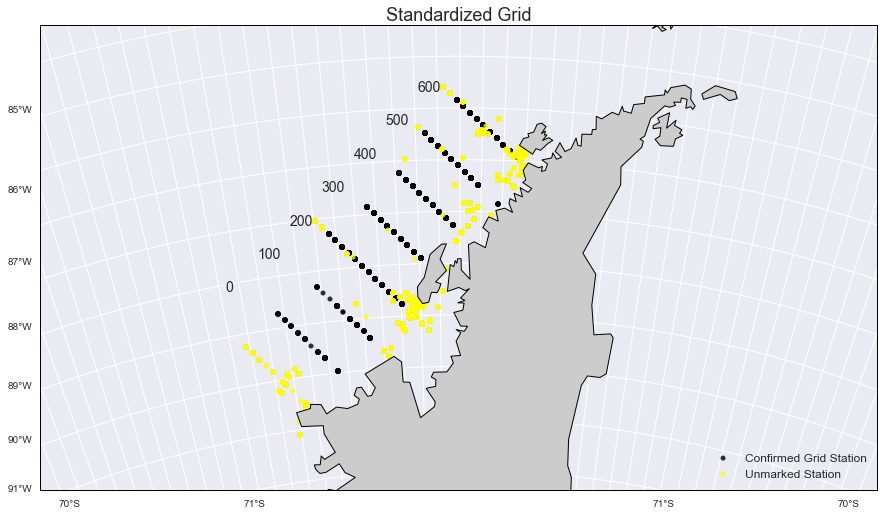

In [13]:
inOrgClean = cord2stationID(inOrg)
map = draw_wAP()
querry = inOrgClean[inOrgClean['stationID'].isin(outOfGrid)==False]
x1 = querry.lon.values
y1 = querry.lat.values
x, y = map(x1, y1)
map.scatter(x, y, color='k', marker='o',s=24,linewidth=.08,alpha=.8,label='Confirmed Grid Station')

querry = inOrgClean[inOrgClean['stationID']=='notFound']
x2 = querry.lon.values
y2 = querry.lat.values
x, y = map(x2, y2)
map.scatter(x, y, marker='o',color='yellow',s=24,linewidth=.08,alpha=.8,label='Unmarked Station')

gridBounds = ['000.220','100.220','200.220','300.220','400.220','500.220','600.220']
gridLabels = newGrid[newGrid['stationID'].isin(gridBounds)]
x3 = gridLabels.lon.values
y3 = gridLabels.lat.values
xS, yS = map(x3, y3)
labels = gridLabels.gridLine.values.astype(int)
for label, xpt, ypt in zip(labels, xS, yS):
    plt.text(xpt-84000, ypt+19000, label,size=14)
plt.legend(scatterpoints=1,
            loc='lower right',
            ncol=1,
            fontsize=12)
plt.title('Standardized Grid')
plt.show()

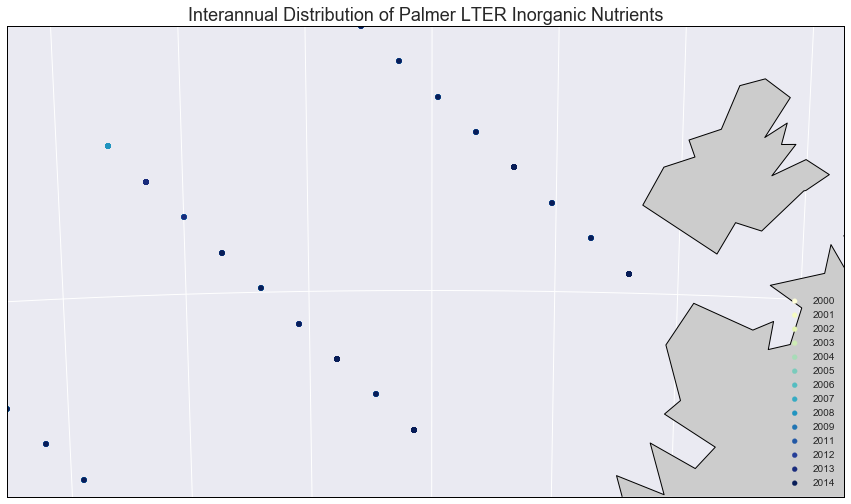

In [14]:
plt_interannual(inOrgClean.loc[inOrgClean['stationID'].isin(outOfGrid)==False],zoom=True)

# Saving the Database <a id='save'></a>
Now each point along the station lines has standardized coordinates and is separated from non-conventional station points!<br>Since this clean-up process is memory-intensive, we want to run it once. To save our progress we can save the cleaned up dataframe as a CSV...
<br><br><i>convert2CSV()</i>
<br>Inputs:
<br>Pandas dataframe (DF), string of write out file.
<br><t>Outputs:
<br><t><t>CSV of the Pandas dataframe in the parent directory.
<br><t>ex . convert2CSV(df,'output.csv')
<br><a href='#h'>Top</a>

In [15]:
def convert2CSV(df,csvout):
    toCSV=pd.DataFrame.to_csv(df,sep=',',line_terminator='\n')
    csvout = open(csvout, 'w')      # opens the file to write into
    csvout.write(toCSV)             # writes df to csv... 
    print("Database transferred to csv...")
    csvout.close()

In [16]:
# Drop the year and month columns.
cleanDF = inOrgClean[['studyName','eventNum','cast','bottle','datetime','stationID','gridLine',
                        'gridStation','lat','lon','percentIrradiance','depth','PO4','SiO4','NO2',
                        'NO3','NH4','Nitrite','notes']]
# filenames
inOrgOutfile = os.path.join(dsPath+'inOrganicNutrientsClean.csv')
gridOutfile = os.path.join(dsPath+'Revised Basic Western Antarctic Peninsula Survey Grid.csv')

# Run it!
convert2CSV(cleanDF, inOrgOutfile)
convert2CSV(newGrid,gridOutfile)

Database transferred to csv...
Database transferred to csv...


# Interannual Nutrient Profiles<a id='profiles'>
<a href='#h'>Top</a>

In [17]:
# Import the clean files
inOrgCleanFile = os.path.join(dsPath+'inOrganicNutrientsClean.csv')
inOrg = read_inOrg(inOrgCleanFile,inOrgCol)

The imported database contains 9101 records.


<header><b>vertical_profile(</b><i>inOrg</i>,<i>maxDepth</i>,<i>drawMLD</i>,<i>method</i>,<i>byStation</i>,<i>station</i><b>)</b></header>
<br>Parameters: 
<br><b>inOrg</b>: <i>Pandas DataFrame</i>
    <br>&emsp;Inorganic nutrients pandas dataframe (DF), 
<br><b>maxDepth</b>: <i>Int or Float</i>
<br>&emsp;depth of the profile in meters, can be neg or pos.
<br><b>drawMLD</b>: <i>Boolean (default, False)</i>
<br>&emsp;set to True (after compiling mld_df) to display the mixed layer depth of each the profile. 
<br><b>method</b>: <i>String (default,'t_sig_down')
<br>&emsp;Method of MLD estimation. Read more about MLD estimation methods <a href='#MLD'>here</a>
<br><b>byStation</b>: <i>Boolean (default, False)</i> 
<br>&emsp;set to True to display one station's interannual profiles.
<br><b>station</b>: <i>String (default,'200.220')
<br> When byStation=True, searches for requested station.
<br>Returns: 
<br>Matplotlib figure containing vertical nutrient profiles for NO<sub>3</sub>+NO<sub>2</sub>,PO<sub>4</sub> and SiO<sub>4</sub>.
<br><br>ex - vertical_profiles(inOrg,200) # for all stations, and no MLD drawn.
<br>vertical_profiles(inOrg,200,drawMLD=True,method='g_sig_down',byStation=True,station='300.140') # for station 300.140 with interannual MLD drawn.

In [18]:
def vertical_profiles(inOrg,maxDepth,drawMLD=False,method='t_sig_down',byStation=False,station='200.220'):
    yearList      = np.array(inOrg.year.unique())                   # List of years from the LTRE
    colorSwatch   = cm.YlGnBu(np.linspace(0, 1, len(yearList) ))    # Colors for plotting
    color         = pd.DataFrame(colorSwatch,columns=['hue','lightness','saturation','other'])
    color['year'] = yearList
    scatMark      = 25

    # Search each station
    if(byStation!=1):
        for station in np.sort(pd.unique(inOrg['stationID'].loc[inOrg['stationID'].isin(outOfGrid)==False].values.ravel())):
            stationData    = inOrg[inOrg.stationID==station]      # get all values in specific station for all stationVar
            stationTime    = stationData.datetime.unique()        # all sample dates from the station
            # Initiate the plot
            fig,ax = plt.subplots(ncols=3,figsize=(14,6),sharey=True)
            # label and limit the 3 axis
            xlabel = [r'PO$_{4}$ [$\mu$m/L]',r'NO$_{3}$+NO$_{2}$ [$\mu$m/L]',r'SiO$_{4}$ [$\mu$m/L]']
            for j in range(3):
                ax[j].locator_params(axis = 'x',nbins=5)
                ax[j].set_xlabel(xlabel[j])
            ax[0].set_ylim([-abs(maxDepth),0])
            ax[0].set_ylabel('Water column height [m]')
            count = 0 
            # Plot each year
            for jj in range(len(stationTime)):
                target    = stationData.loc[stationData.datetime==stationTime[jj]]  # get only values from selected stationInterannualVar
                if(len(target.index)<=3):                        # make sure there are more than 3 points per time
                    break
                else:
                    colorYear = (color[['hue','lightness','saturation']][color.year==np.asarray(target.year.unique(), dtype=np.float)[0]]).values
                    # For each chemical tracer
                    chem = ['PO4','Nitrite','SiO4']
                    for k in range(len(chem)):
                        df = target.loc[(target[chem[k]]!=skip) & (target[chem[k]].notnull())]
                        x = df[chem[k]].values
                        y = df['depth'].values*-1
                        if(x.any()):
                            labels = np.asarray(target.year, dtype=np.int)[0]
                            ax[k].scatter(x,y ,marker=mark[jj%5],s=scatMark,color=colorYear,zorder=1,linewidth=.2,label=labels)
                            ax[k].plot(x,y,color=colorYear[0],zorder=10)
                            ax[k].legend(scatterpoints=1,loc='lower left',ncol=1,fontsize=10)
                            if(drawMLD==1):
                                MLD = mld_df.loc[(mld_df.stationID==stationID[i]) & (mld_df.year==labels)]
                                if (len(MLD)>1):
                                    ax[k].axhline(y=MLD[method].iloc[0]*-1,linewidth=2,color=colorYear[0],alpha=0.8,zorder = 3)
                            count +=1
            if(count==0):
                plt.close() 
            fig.suptitle(r'Interannual Variability of Inorganic Nutrients at Station '+np.asarray(target.stationID)[0]+\
                             ' ('+str(np.asarray(target.lat)[0])+','+str(np.asarray(target.lon)[0])+')',fontsize=22)
            plt.show()
            plt.tight_layout      
        # Or get profile of specified station...
    else:
        stationData    = inOrg[inOrg.stationID==station] # get all values in specific station for all stationVar
        stationTime    = stationData.datetime.unique()        # all sample dates from the station
        # Initiate the plot
        fig,ax = plt.subplots(ncols=3,figsize=(14,6),sharey=True)
        # label and limit the 3 axis
        xlabel = [r'PO$_{4}$ [$\mu$m/L]',r'NO$_{3}$+NO$_{2}$ [$\mu$m/L]',r'SiO$_{4}$ [$\mu$m/L]']
        for j in range(3):
            ax[j].locator_params(axis = 'x',nbins=5)
            ax[j].set_xlabel(xlabel[j])
        ax[0].set_ylim([-abs(maxDepth),0])
        ax[0].set_ylabel('Water column height [m]')
        count = 0 
        # Plot each year
        for jj in range(len(stationTime)):
            target    = stationData.loc[stationData.datetime==stationTime[jj]]  # get only values from selected stationInterannualVar 
            colorYear = (color[['hue','lightness','saturation']][color.year==np.asarray(target.year.unique(), dtype=np.float)[0]]).values
            # For each chemical tracer
            chem = ['PO4','Nitrite','SiO4']
            for k in range(len(chem)):
                df = target.loc[(target[chem[k]]!=skip) & (target[chem[k]].notnull())]
                x = df[chem[k]].values
                y = df['depth'].values*-1
                if(x.any()):
                    labels = np.asarray(target.year, dtype=np.int)[0]
                    ax[k].scatter(x,y ,marker=mark[jj%5],s=scatMark,color=colorYear,zorder=1,linewidth=.2,label=labels)
                    ax[k].plot(x,y,color=colorYear[0],zorder=10)
                    ax[k].legend(scatterpoints=1,loc='lower left',ncol=1,fontsize=10)
                    if(drawMLD==1):
                        MLD = mld_df.loc[(mld_df.stationID==stationID[i]) & (mld_df.year==labels)]
                        if (len(MLD)>1):
                            ax[k].axhline(y=MLD[method].iloc[0]*-1,linewidth=2,color=colorYear[0],alpha=0.8,zorder = 3)
                    count +=1
            
        if(count==0):
            plt.close() 
        fig.suptitle(r'Interannual Variability of Inorganic Nutrients at Station '+np.asarray(target.stationID)[0]+\
                         ' ('+str(np.asarray(target.lat)[0])+','+str(np.asarray(target.lon)[0])+')',fontsize=22)
        plt.show()
        plt.tight_layout      

With vertical_profiles, we can inspect how each stations varies interanually, or by individual station when byStation=True, and station='stationID' are set as arguments.

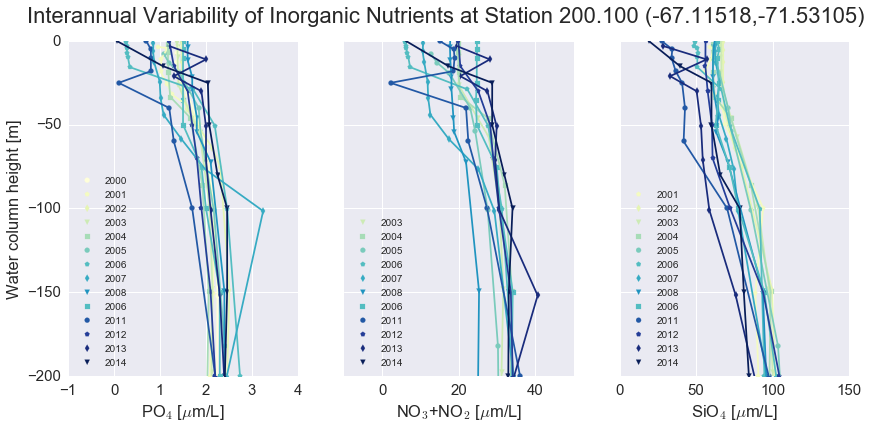

In [19]:
vertical_profiles(inOrg,200,byStation=True,station='200.100')

Now we know how each station changes with depth over time, but these depth profiles are not informative as standalone figures. To get more insight let's compare each cruise across the years and averaged among years. We can do so by interpolating between stations.

# Interannual Surface Interpolation Algorithm<a id='inter'></a>
<a href='#h'>Top</a>

In [20]:
def interpolate(df,tracer,MLD=False):
    # Querry the database and clean up
    tracer_df  = df.loc[(df[tracer]!=skip) & 
                      (df[tracer].notnull()) & 
                      (df['stationID'].isin(outOfGrid)==False)]
    
    # choose a title and see if the tracer analysis depth-dependent.
    if(tracer=='Nitrite'):
        title = 'Surface NO$_{3}$+NO$_{2}$'
        tracer_df = tracer_df[tracer_df['depth']<=surfDepth]
    elif(tracer=='PO4'):
        title = 'Surface PO$_{4}$'
        tracer_df = tracer_df[tracer_df['depth']<=surfDepth]
    elif(tracer=='SiO4'):
        title = 'Surface SiO$_{4}$'
        tracer_df = tracer_df[tracer_df['depth']<=surfDepth]
    else:
        title = 'Mixed Layer Depth'
        tracer_df = tracer_df.loc[(tracer_df[tracer]<200) & (tracer_df[tracer]>0)]

    # Interpolate and plot for each year
    for year in pd.unique(tracer_df.year.values.ravel()):
        querry  = tracer_df[tracer_df['year']==year]
        # Define the plotable elements
        x = querry.lon.values
        y = querry.lat.values
        z = querry[tracer].values
        # If it's not empty let's interpolate!
        if(len(x)>5):
            # plot data points.
            plt.scatter(x,y,facecolors='none', edgecolors='k',s=26, zorder=3)
            if(MLD==True):
                querr2  = mld_df[mld_df['year']==year]
                x = querr2.lon.values
                y = querr2.lat.values
                z = querr2['clustered_MLD']
                plt.scatter(x,y, color='orange',s=26,zorder = 2)
            # define grid.
            xi = np.linspace(x.min(),x.max(),300)
            yi = np.linspace(y.min(),y.max(),300)
            # grid the data.
            zi = abs(griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic'))
            # contour the gridded data.
            plt.contourf(xi,yi,zi,12,cmap=cMap,zorder=1)
            plt.colorbar() # draw colorbar
            plt.xlim(min(x),max(x))
            plt.ylim(min(y),max(y))
            plt.title('Interpolated '+title+' '+str(np.asarray(querry.year)[0])+' (%d points)' % len(x))
            plt.show()

# Average Surface Interpolation Algorithm<a id='interA'></a>
<a href='#h'>Top</a>

In [22]:
def interpolate_average(df,tracer):
    # Querry the database and clean up
    tracer_df  = df.loc[(df[tracer]!=skip) & (df[tracer].notnull())& (df['stationID'].isin(outOfGrid)==False)]
    # Title for plot
    if(tracer=='Nitrite'):
        title = 'Surface NO$_{3}$+NH$_{4}$'
        tracer_df = tracer_df.loc[tracer_df['depth']<=surfDepth]
    elif(tracer=='PO4'):
        title = 'SurfacePO$_{4}$'
        tracer_df = tracer_df.loc[tracer_df['depth']<=surfDepth]
    elif(tracer=='SiO4'):
        title = 'Surface SiO$_{4}$'
        tracer_df = tracer_df.loc[tracer_df['depth']<=surfDepth]
    else:
        title = 'MLD'
        tracer_df = tracer_df.loc[(tracer_df[tracer]<200) & (tracer_df[tracer]>0)]
    # Average surface values across years
    stationList    = tracer_df.stationID.unique()
    lons = []
    lats = []
    nuits = []
    for stationID in stationList:
        querry= tracer_df[tracer_df['stationID']==stationID]
        if(len(querry.year.unique())>=5):
            lons.append(np.asarray(querry.lon)[0])
            lats.append(np.asarray(querry.lat)[0])
            nuits.append(abs(np.nanmean(querry[tracer])))
    # define grid.
    xi = np.linspace(min(lons),max(lons),360)
    yi = np.linspace(min(lats),max(lats),360)
    # grid the data.
    zi = griddata((lons, lats), nuits, (xi[None,:], yi[:,None]), method='cubic')
    # contour the gridded data.
    CS = plt.contourf(xi,yi,zi,15,cmap=cMap)
    plt.colorbar() # draw colorbar
    # plot data points.
    #plt.scatter(lats,lons,c=nuts,marker='o',s=26,cmap=cMap)
    plt.scatter(lons,lats,facecolors='none', edgecolors='k',s=26)
    plt.xlim(min(lons),max(lons))
    plt.ylim(min(lats),max(lats))
    plt.title(r'Summertime Averages of '+title+' (%d points)' % len(nuits))
    plt.show()

# NH<sub>4</sub>+NO<sub>3</sub>  Interannual Average <a id='interANitrite'></a>
<a href='#h'>Top</a>

In [23]:
chem  = ['Nitrite','PO4','SiO4']

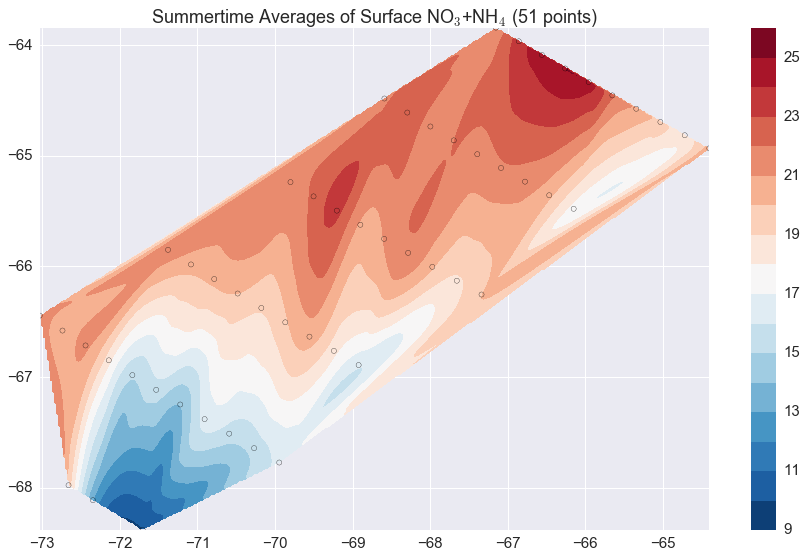

In [24]:
interpolate_average(inOrg,chem[0])

# NH<sub>4</sub>+NO<sub>3</sub>  Interannual Surface Interpolation <a id='interNitrite'></a>
<a href='#h'>Top</a>

2003


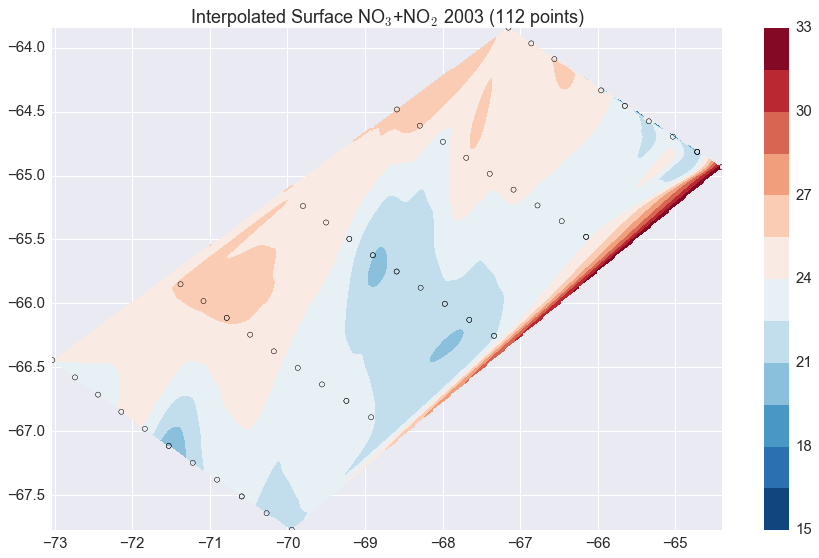

2004


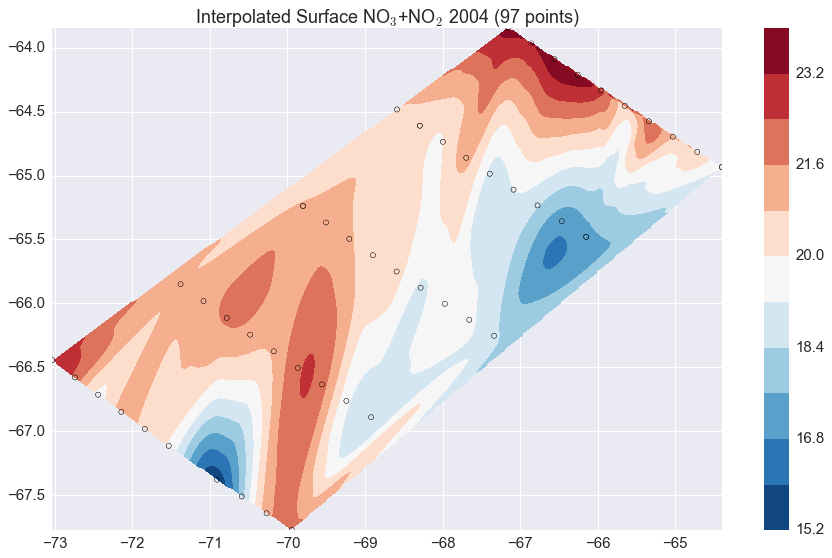

2005


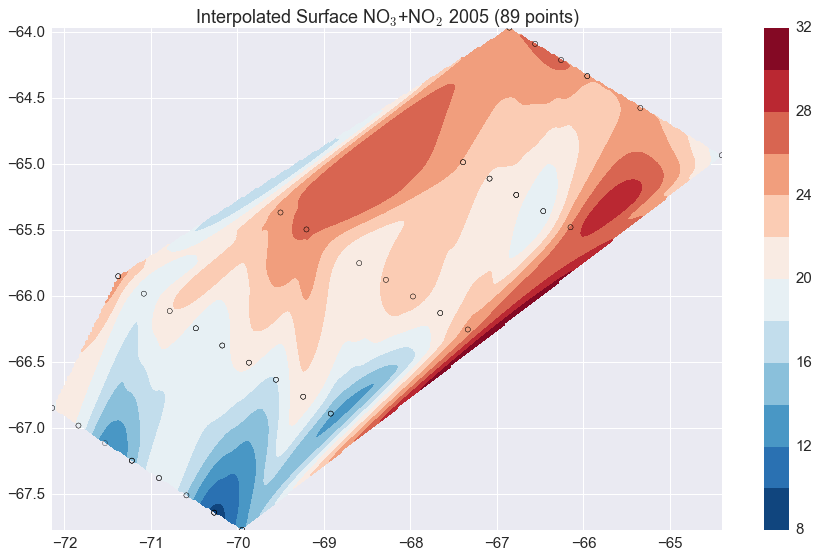

2006


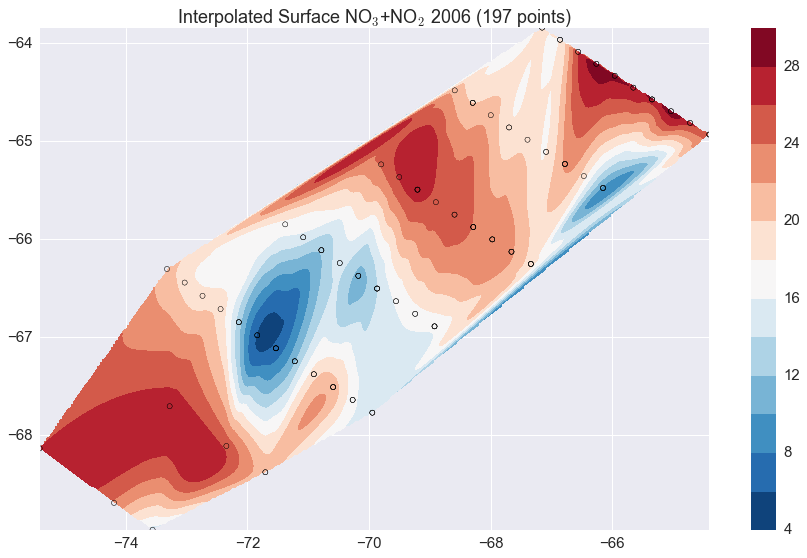

2007


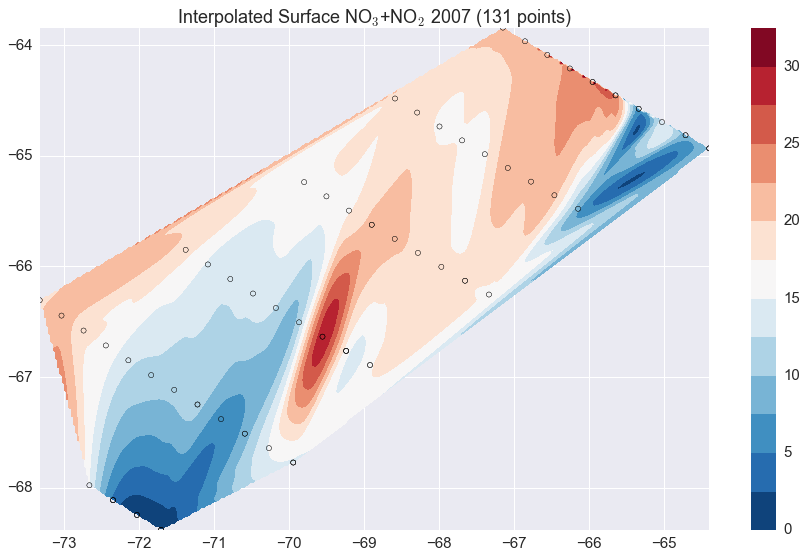

2008


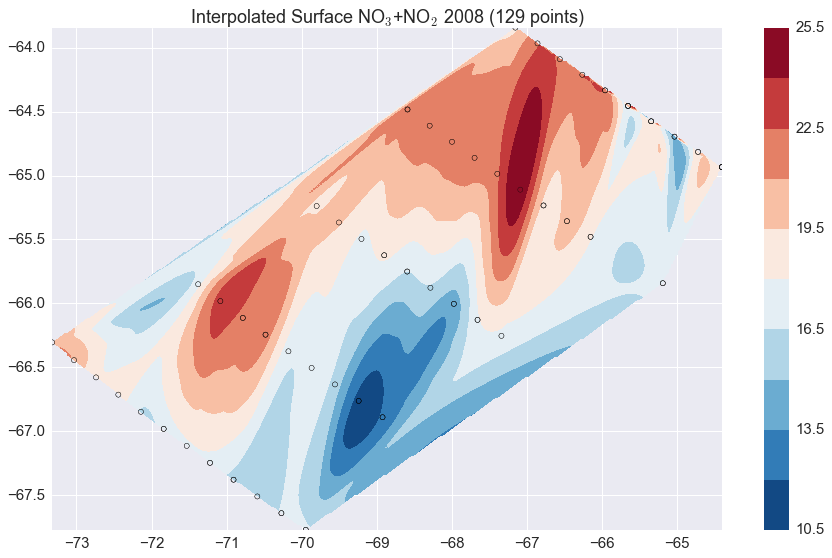

2009


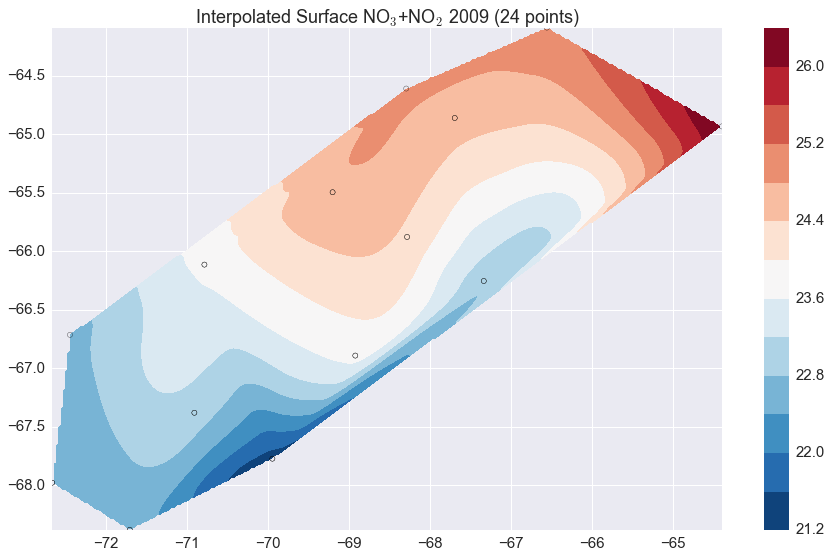

2011


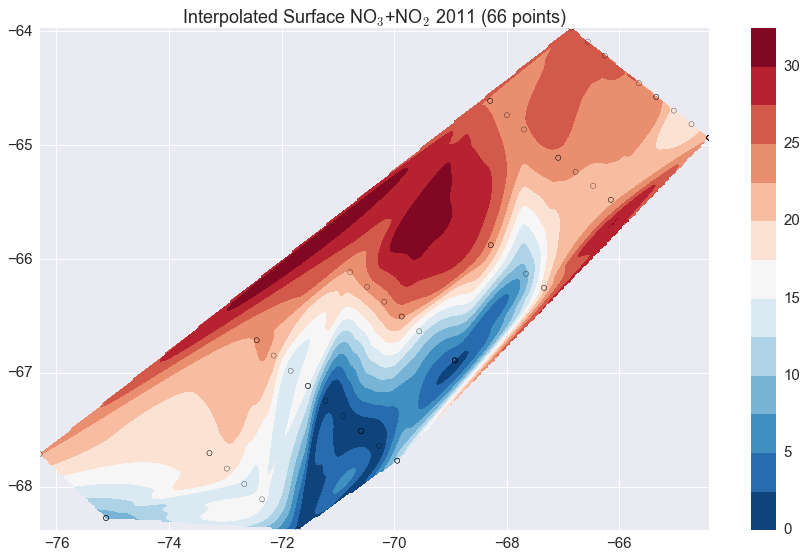

2001
2012


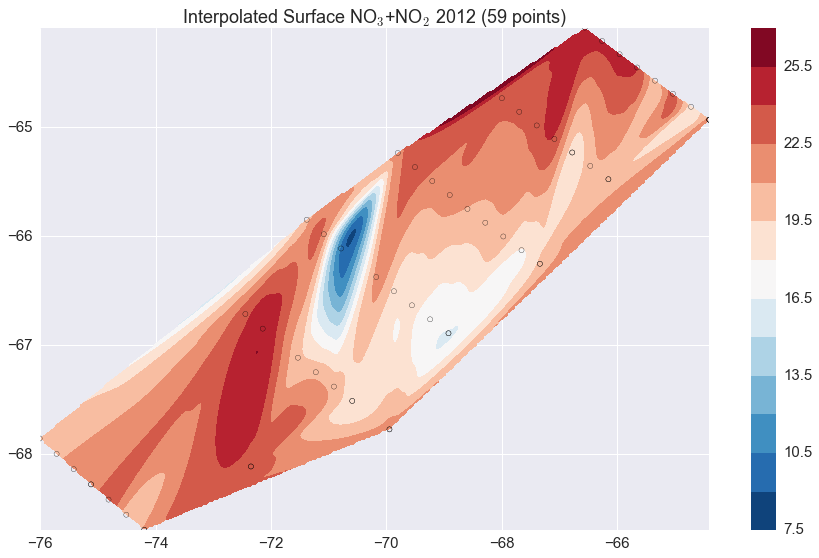

2013


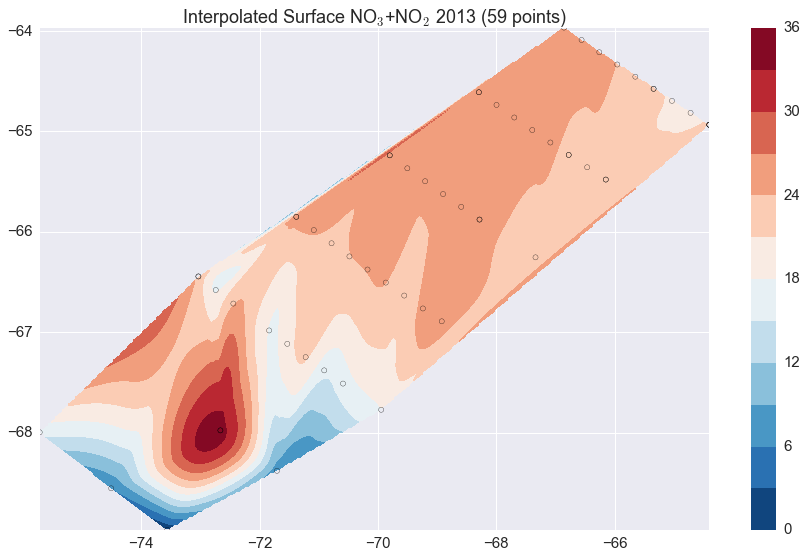

2014


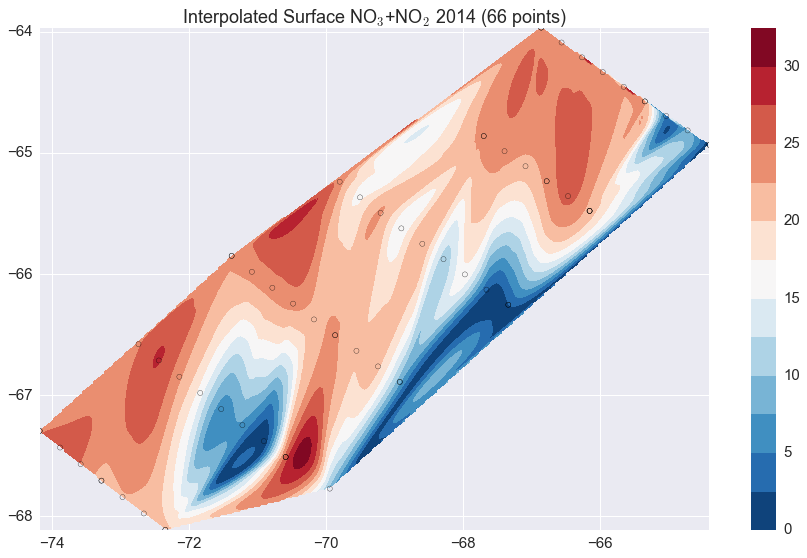

In [25]:
interpolate(inOrg,chem[0])

We can leverage these combined NO<sub>2</sub> NO<sub>3</sub> measurements to calculate how much inorganic carbon has been taken out of the water column by biotic factors (Phytoplankton). This Biogeochemical measurement is called Net Primary Production, and can be attained with a help from Physical parameters... namely, Mixed Layer Depth (MLD). The integrated area down to the MLD of combined NO<sub>2</sub> NO<sub>3</sub> represents the total nutrients taken out of the homogenous water column by Phytoplankton. With this number, we can reverse engineer how much CO<sub>2</sub> has been sequestered using a stoichiometric ratio of elements found in Marine biota called the Redfield Ratio.

# Estimating MLD <a id='MLD'></a>
The along with inorganic nutrients, CTD profile are taken on the annual cruise along the wAP. The profile is recorded on the way down and on the way back up to the ship. For this reason, the MLD estimations are taken from both directions and using two methods highlighted in Holte and Talley (2009)-- including the <b>Threshold Method</b> by
<a target="_blank" href='http://www.ifremer.fr/cerweb/deboyer/publications/2004_deBoyerMontegut_et_al_JGR.pdf'>de Boyer Montegut <i>et al.</i> (2004)</a> and the
<b>Gradient Method</b> by
<a target="_blank" href='http://www.aoml.noaa.gov/phod/docs/Dong_etal_2008.pdf'>Dong <i>et al.</i> (2008)</a>
<br><a href='#h'>Top</a>

In [26]:
# files
mldPath        = 'package_650/**/*.std'
mldOutfile     = os.path.join(dsPath+'Palmer_MLD.json')

In [27]:
# values for threshold (t_) and gradient(g_) MLD estimations
t_threshT = 0.2    # celsius
t_threshS = 0.03   # kg/m^3
g_threshT = 0.005  # celsius
g_threshS = 0.0005 # kg/m^3

def find_mld(path):
    mld_list  = [] # initialize a list for all dictionaries containing MLD estimates.
    for filename in glob.iglob(path, recursive=True):
        # First let's read each CTD profile into a pandas Dataframe
        lines = [line.split() for line in open(filename,'r',errors="ignore")]
        cols  = [" ".join(line).lower() for line in lines[1:25] if len(line)<12]
        rows  = lines[len(cols)+1:]
        df    = pd.DataFrame(data=np.reshape(rows,(len(rows),len(cols))),columns=cols)
    
        mld = {} # initialize a dictionary to store all the MLD estimates

        # add propoer leading zeros to lines
        station,line = lines[0][5].split(".")
        if("-" not in line):
            mld['stationID']= station+"."+str("%03d" % (int(line),))
            mld['year']   = '20'+filename.split('/')[1][:2]
        else:
            mld['stationID']= station+"."+str("%04d" % (int(line),))
            mld['year']   = '20'+filename.split('/')[1][:2]
        
        # Boolean switches
        sFound  = 0
        t1Found = 0
        t2Found = 0
        pFound  = 0
        dFound  = 0

        # check each column in the uploaded file for potential desnity, temps, pressure, and depth
        for col in cols:
            if(sFound==0 and 'sigma' in col):
                sigmaCol = col
                sFound = 1

            elif(t1Found==0 and 'temperature' in col and 'potential' not in col):
                tempCol = col
                t1Found = 1

            elif(t2Found==0 and 'temperature' in col and 'potential' not in col):
                temp2Col = col
                t2Found =1

            elif('pressure' in col and pFound==0):
                presCol = col
                pFound = 1

            elif('depth' in col and dFound==0):
                depthCol = col
                dFound = 1

        # rename the columns
        df = df.rename(columns={sigmaCol: 'sigma', 
                                tempCol: 'temp1', 
                                temp2Col: 'temp2', 
                                presCol : 'pres',
                                depthCol : 'depth'})

        for col in ['pres','sigma','temp1','temp2','depth']:
            df[col]  = pd.to_numeric(df[col], errors='coerce')

        #The measurement closest to 10 dbar is used as the reference value, now enter Holte and Talley 2009.
        ref = df.loc[df['pres']==5].index
        if(len(ref)==2):
            df[ref[0]:ref[1]]
            bottomUp = True
        elif(len(ref)==1):
            if(ref[0]<(len(df)/2)):
                df[ref[0]:]
                bottomUp = False
            else:
                df[:ref[0]]
                bottomUp = True
                
        # Sigma Threshold
        for isopyc in df['sigma']:
            if (abs(isopyc-np.asarray(df['sigma'].head(1))[0]) > t_threshS):
                mld['t_sig_down']= np.asarray(df['depth'].loc[df['sigma']==isopyc].values)[0]
                break
        if(bottomUp==True):
            for isopyc in reversed(df['sigma']):
                if (abs(isopyc-np.asarray(df['sigma'].tail(1))[0]) > t_threshS):
                    mld['t_sig_up']= np.asarray(df['depth'].loc[df['sigma']==isopyc].values)[0]
                    break

        # Temp Threshold 1
        for isotherm in df['temp1']:
            if (abs(isotherm-np.asarray(df['temp1'].head(1))[0]) > t_threshT):
                mld['t_t1_down']= np.asarray(df['depth'].loc[df['temp1']==isotherm].values)[0]
                break
        if(bottomUp==True):
            for isotherm in reversed(df['temp1']):
                if (abs(isotherm-np.asarray(df['temp1'].tail(1))[0]) > t_threshT):
                    mld['t_t1_up']= np.asarray(df['depth'].loc[df['temp1']==isotherm].values)[0]
                    break
        
        # Calculate the finite difference slope
        sigSlope = np.diff(df['sigma'])/np.diff(df['pres'])
        t1Slope  = np.diff(df['temp1'])/np.diff(df['pres'])
        t2Slope  = np.diff(df['temp2'])/np.diff(df['pres'])
        ms       = len(t1Slope)-1

        for i in range(ms):
            if(abs(t1Slope[i])>g_threshT):
                mld['g_t1_down']=df['depth'].iloc[i+1]
                break
        if(bottomUp==True):        
            for i in reversed(range(ms)):
                if(abs(t1Slope[i])>g_threshT):
                    mld['g_t1_up']=df['depth'].iloc[i+1]
                    break

        for i in range(ms):
            if(abs(sigSlope[i])>g_threshS):
                mld['g_sig_down']=df['depth'].iloc[i+1]
                break
        if(bottomUp==True):
            for i in reversed(range(ms)):
                if(abs(sigSlope[i])>g_threshS):
                    mld['g_sig_up']=df['depth'].iloc[i+1]
                    break
        mld_list.append(mld)
    # Save the MLD estimates    
    with open(mldOutfile, 'w') as file:
        json.dump(mld_list, file, indent=4)
    print('CTD data scraped and dumped')
# run it!
find_mld(mldPath)

CTD data scraped and dumped


NameError: name 'mld_df' is not defined

## Choosing MLD
One preliminary avenue of picking a MLD using a percentile approach for the MLD estimates. This approach is segmented between up and down cast, as up cast profiles are taken at a slower rate.

Another method used by Holte and Talley (2009) is cluster analysis. For this I build off a runction from <a target="_blank" href='http://stackoverflow.com/a/14783998/5094480'>Raymond Hettinger</a>, to search through each station's MLD estimates and cluster values based on a scaling gap. The largest cluster is then averaged and returned.
<br><a href='#h'>Top</a>

In [29]:
# Merge the MLD estimates with the wAP grid for plot-ability.
mld_df = pd.merge(left=pd.read_json(mldOutfile),right=newGrid,on='stationID',how='inner')

In [30]:
# Cluster based MLD estimation.
def cluster(data, maxgap):
    data = data[~np.isnan(data)]
    if(data.any()):
        data.sort()
        groups = [[data[0]]]
        for x in data[1:]:
            if abs(x - groups[-1][-1]) <= (maxgap+(x/10)):
                groups[-1].append(x)
            else:
                groups.append([x])
        # check for largest cluster
        maxClusterSize = 0
        for group in groups:
            if(len(group)>maxClusterSize):
                maxClusterSize = len(group)
                meanCluster = np.mean(group) 
        return meanCluster

In [31]:
mld_df['clustered_MLD']=[cluster(row, maxgap=4) for row in mld_df[['g_sig_up',
                                                                   'g_t1_up',
                                                                   't_sig_up',
                                                                   't_t1_up',
                                                                   'g_sig_down',
                                                                   'g_t1_down',
                                                                   't_sig_down',
                                                                   't_t1_down']].values]

# MLD Coverage Relative to Nutrient Samples. <a id='MLD_coverage'></a>
How do we know if our MLD estimates (orange) have enough coverage to calculate NPP for for each set of annual inorganic nutrient measurements (hollow)? For hollow points-- where we lack CTD data, we will use interpolated MLD (filled contour) to calculate the NPP. For this reason, how MLD is estimated and interpolated can make or break our restults.
<br><a href='#h'>Top</a>

2003


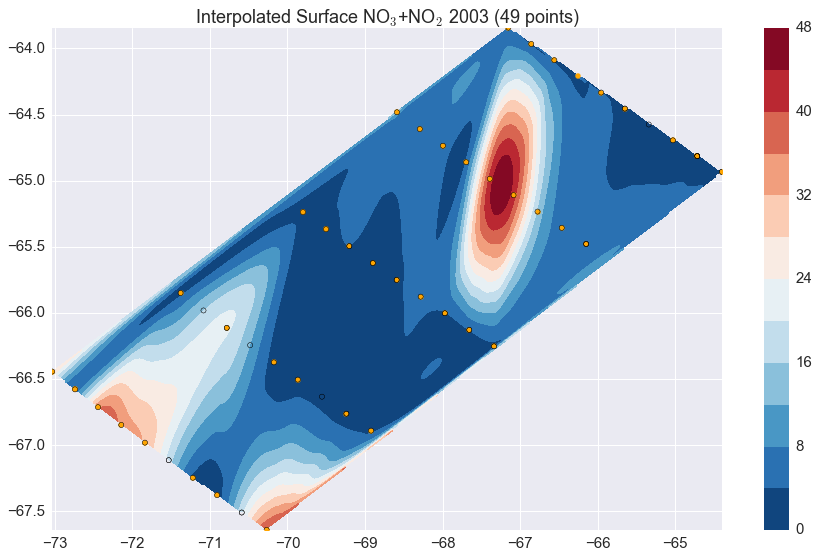

2004


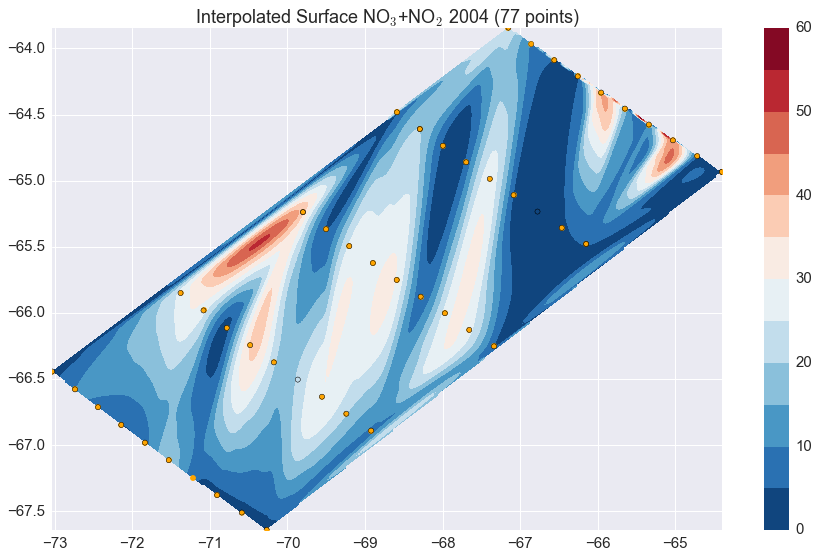

2005


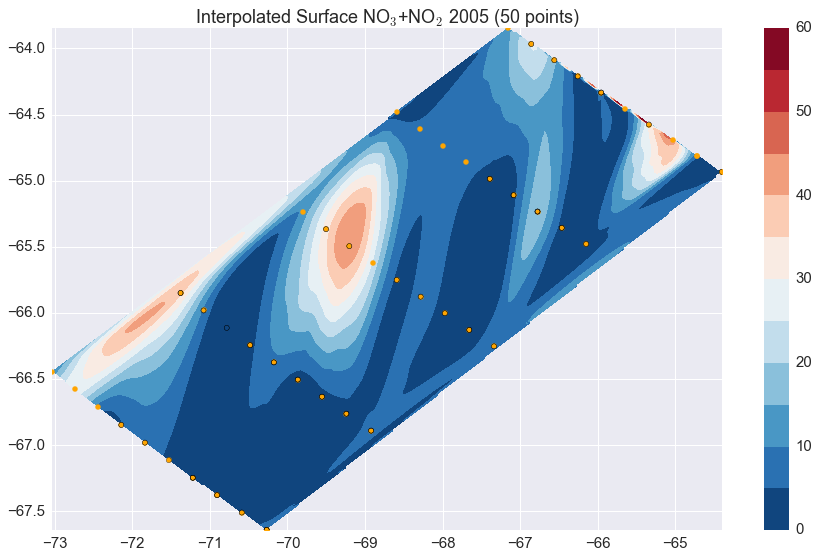

2006


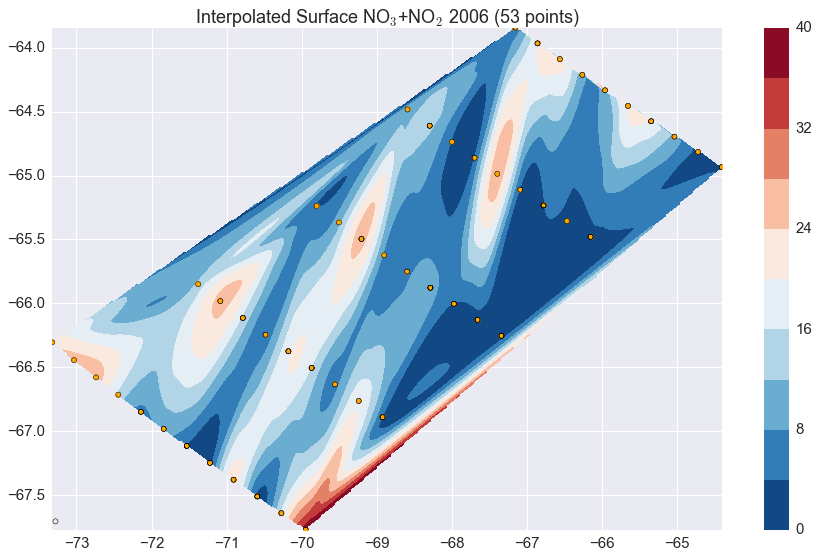

2007


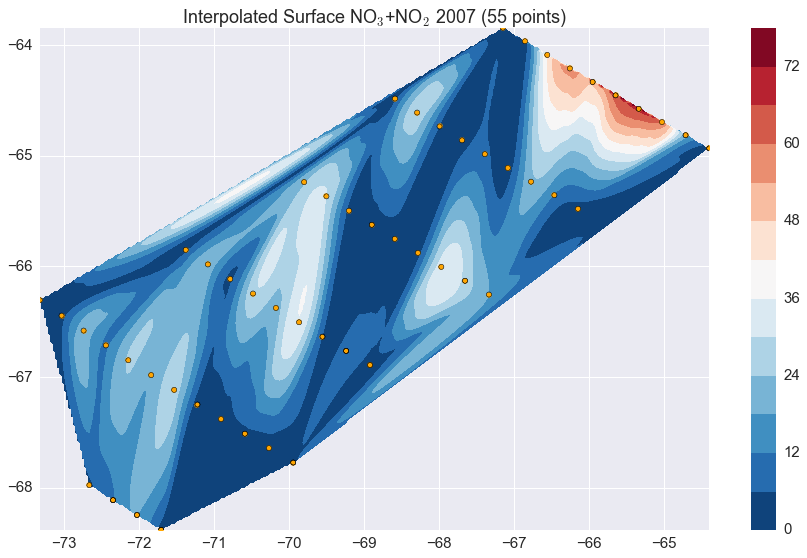

2008


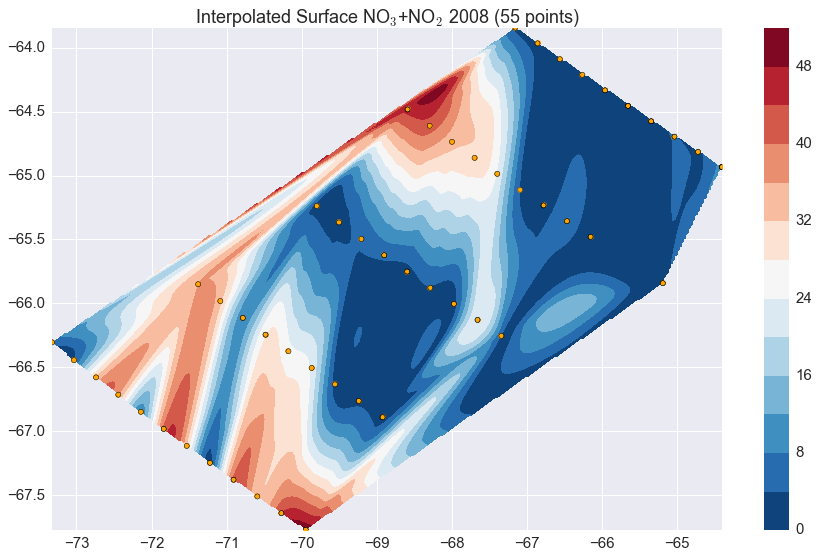

2009


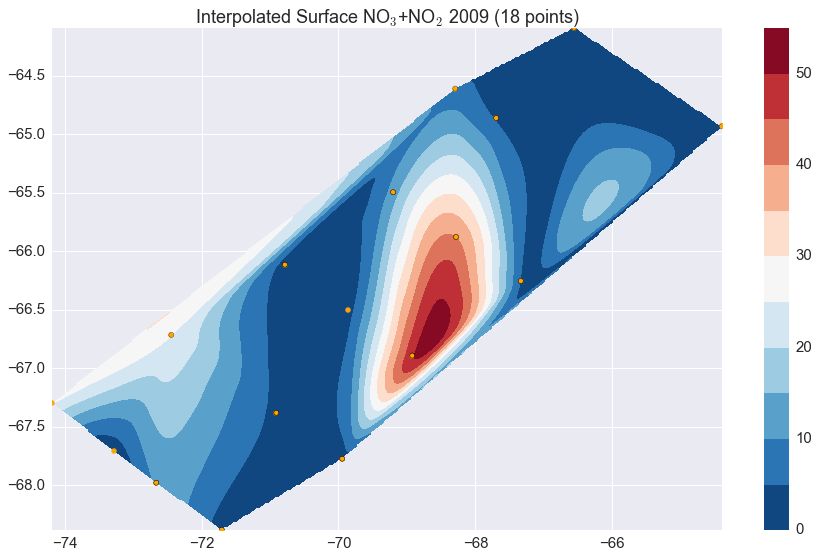

2011


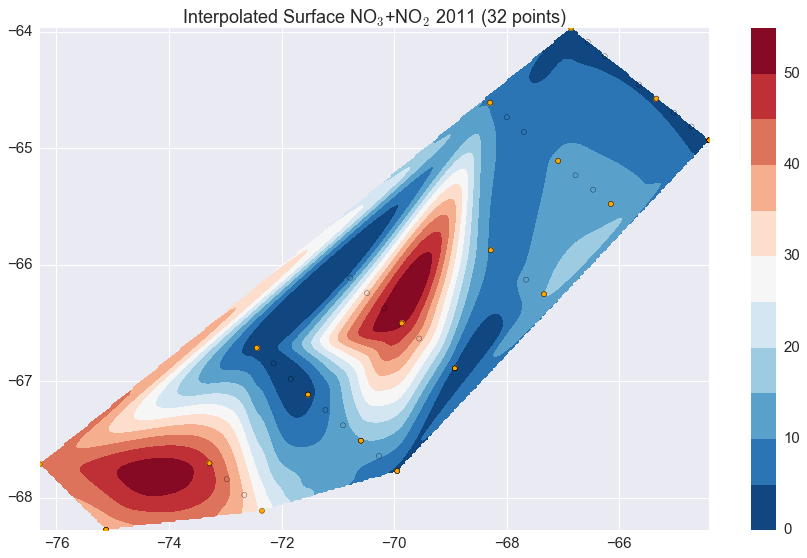

2001
2012


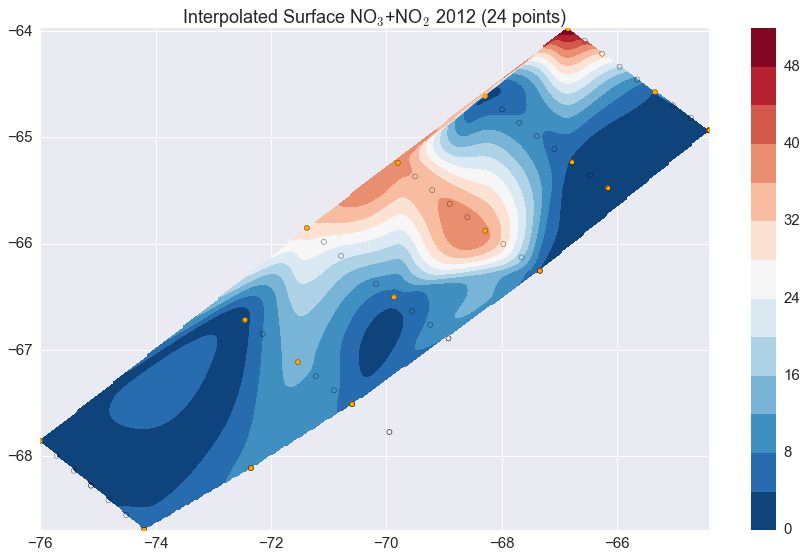

2013


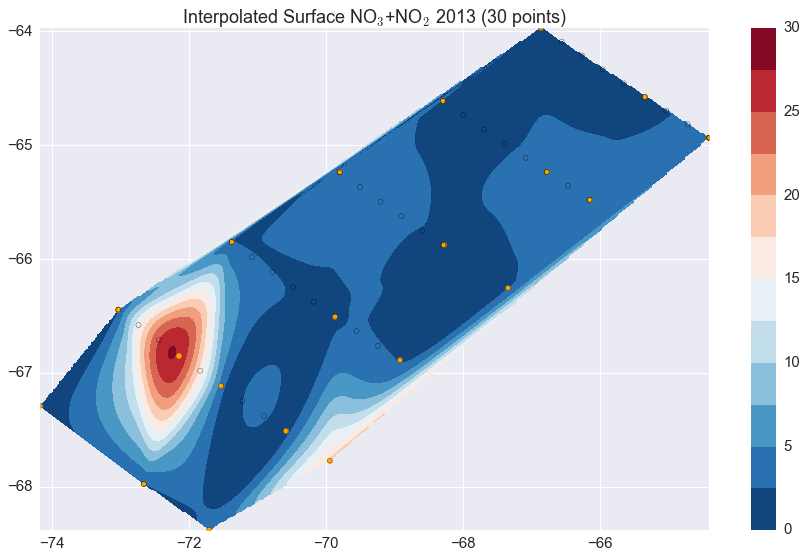

2014


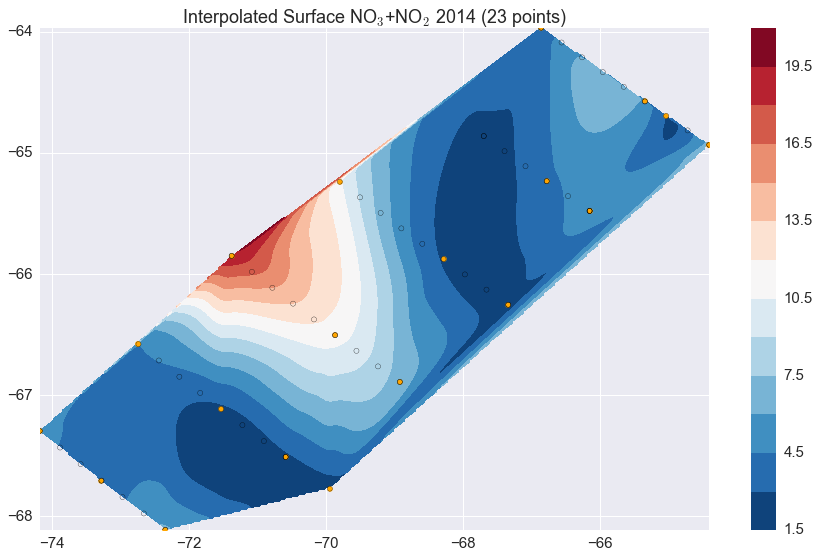

In [32]:
interpolate(df=inOrg,tracer='Nitrite',MLD=True)

## Interannual MLD<a id='MLD_plot'></a>
The interpolate() function can be used for other MLD estimation methods, as well as for interannual averages.
<br><a href='#h'>Top</a>

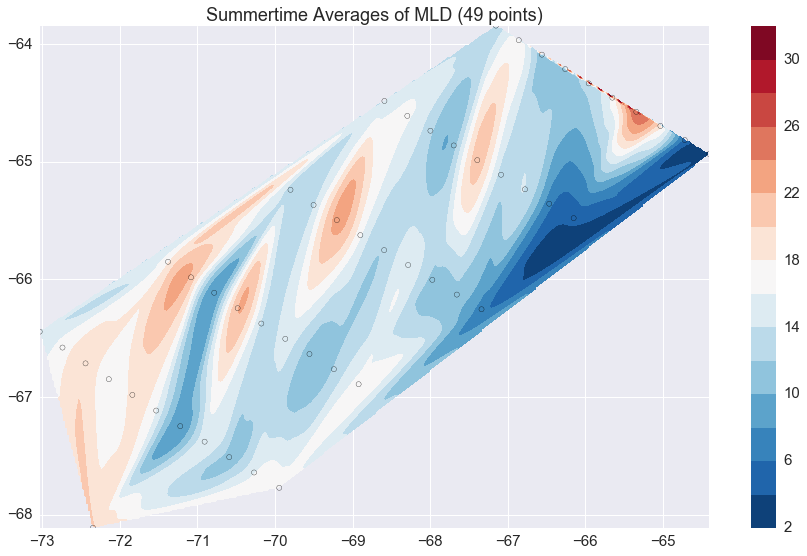

In [33]:
interpolate_average(mld_df,'clustered_MLD')

## Calculating Net Primary Production (NPP) <a id='NPP'></a>
With a MLD, we can calculate how much nutrients are removed from the water column by integrating the combined NO<sub>2</sub> NO3<sub>3</sub> along the MLD. To account for the resolution of the MLD, we can interpolate the NO<sub>2</sub> NO3<sub>3</sub> concentration to the desired MLD.
<br><a href='#h'>Top</a>

In [53]:
# Files
nppOutfileNOX = os.path.join(dsPath+'NPP.json')
nppOutfileSiO4 = os.path.join(dsPath+'NPP_SiO4.json')
nppOutfilePO4 = os.path.join(dsPath+'NPP_PO4.json')

In [88]:
# seach interpolated MLD dictionary--parameterized in compile_NPP(), for values closest to missing station.
def station_MLD(stationID,zi,df,xi_coords,yi_coords):
    mld = zi[xi_coords[round(float(df.loc[df.stationID==stationID].lon.values[0]),1)], 
             yi_coords[round(float(df.loc[df.stationID==stationID].lat.values[0]),1)]]
    return(mld.mean())

In [86]:
# interpolated
def get_NPP(df,station,tracer,mld):
    depSlice = df.loc[df['stationID']==station]
    if not(depSlice.empty):
        mld_tracer = np.interp(mld,depSlice['depth'], depSlice[tracer])
        # slice the profile after using the profile beyong the MLD to interpolate.
        depSlice = depSlice.loc[depSlice['depth']<=mld]
        nuit_profile = np.append(depSlice[tracer].values,mld_tracer)
        mld_depth = np.append(depSlice['depth'].values,mld)
        return((mld*mld_tracer) - simps(nuit_profile,mld_depth)) # integrate from depth to surface using profile.
    else:
        return('Could not find?')

In [92]:
nppOutfile = os.path.join(dsPath+'NPP.json')
def compile_NPP(method='t_sig_down',tracer='Nitrite',outfile=nppOutfile,warning=False):
    years = [2003,2004,2005,2006,2007,2008,2009,2011,2012,2013,2014]
    NPP_list = []
    for year in years:
        if(warning==True):
            print("***",year,"***")
        # Querry the databases and clean up
        querryMLD  = mld_df.loc[(mld_df[method]!=skip) & 
                          (mld_df[method].notnull()) & 
                          (mld_df['stationID'].isin(outOfGrid)==False)&
                          (mld_df['year']==year)]

        querryInOrg = inOrg.loc[(inOrg[tracer]!=skip) & 
                          (inOrg[tracer].notnull()) & 
                          (inOrg['stationID'].isin(outOfGrid)==False)&
                          (inOrg['year']==year)]
        
        # Grid and interpolate MLD.
        x = np.round(querryMLD.lon.values,4)
        y = np.round(querryMLD.lat.values,4)
        z = querryMLD[method].values
        # If it's not empty let's interpolate!
        if(len(x>4)):
            # define grid.
            xi = np.linspace(x.min(),x.max(),360)
            yi = np.linspace(y.min(),y.max(),360)
            # grid the data.
            zi = abs(griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic'))
            # document the linspace coord pairs
            xi_coords = {round(float(value),1): index for index, value in enumerate(xi)}
            yi_coords = {round(float(value),1): index for index, value in enumerate(yi)}

            # Go through each station measurement of inorganic nuitrients
            for station in pd.unique(querryInOrg['stationID'].values.ravel()):
                # check if the station and year exist in the MLD data
                mld_S = querryMLD.loc[querryMLD['stationID']==station]
                # if not, check interp...
                if(mld_S.empty):
                    try:
                        if not(pd.isnull(station_MLD(station,zi,querryInOrg,xi_coords,yi_coords))):
                            NPP_list.append({'year': year,
                                         'stationID': station,
                                         'MLD' : station_MLD(station,zi,querryInOrg,xi_coords,yi_coords), 
                                         'interp':'True',
                                         'NPP': get_NPP(querryInOrg,station,tracer,station_MLD(station,zi,querryInOrg,xi_coords,yi_coords))})
                    except (KeyError,IndexError) as e:
                        if(warning==True):
                            print(station,"index not found")
                        # TODO: reference annual value for index error?? reference nearest enighbor for key error?

                else:
                    NPP_list.append({'year': year,
                                     'stationID': station,
                                     'MLD': mld_S[method].mean(),
                                     'interp': 'False',
                                     'NPP': get_NPP(querryInOrg,station,tracer,np.nanmean(mld_S[method]))})
    with open(outfile, 'w') as file:
        json.dump(NPP_list, file, indent=4)
compile_NPP(method='clustered_MLD',tracer='Nitrite',outfile=nppOutfile)

read the json file into a pandas DF, read as text to avoid nans. Chained solution to <a target="_blank" href='http://stackoverflow.com/q/29875244/5094480'>this</a> Stackoverflow answer.

In [93]:
NOX_df = pd.DataFrame(json.loads(open(nppOutfile,'r').read()))
NOX_df =pd.merge(left=NOX_df,right=newGrid,on='stationID',how='inner')

2003


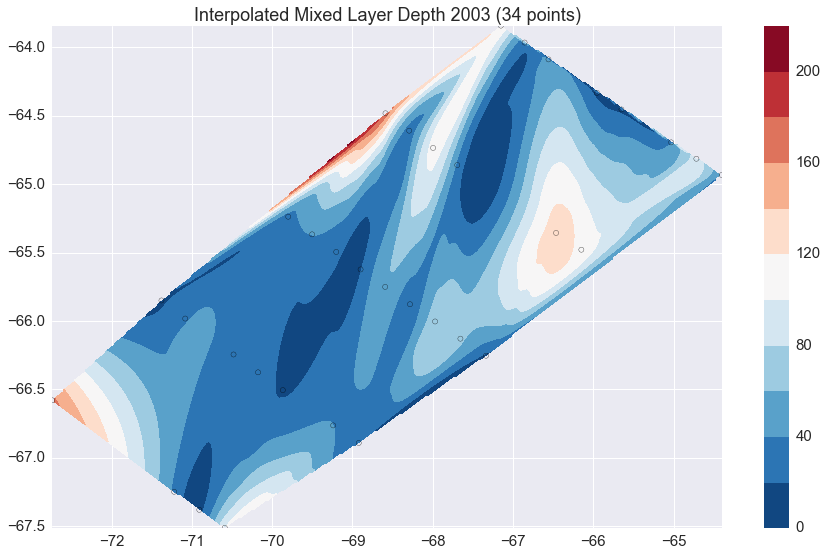

2004


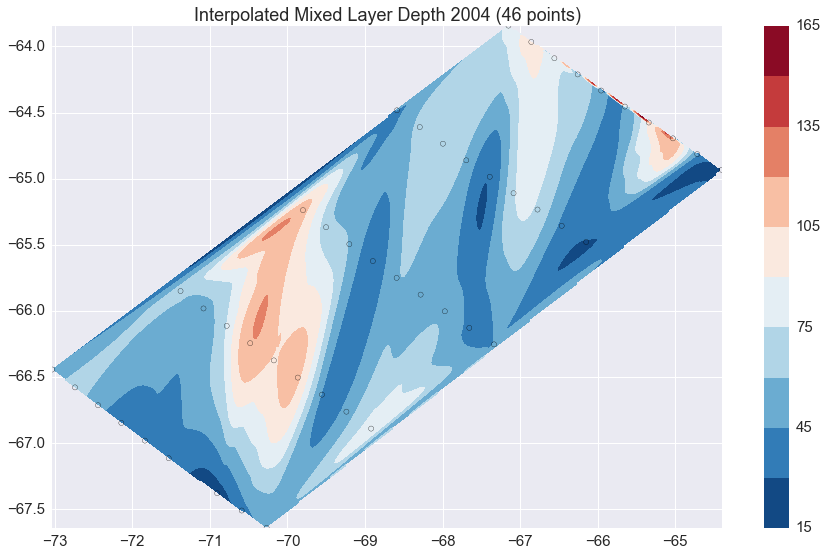

2005


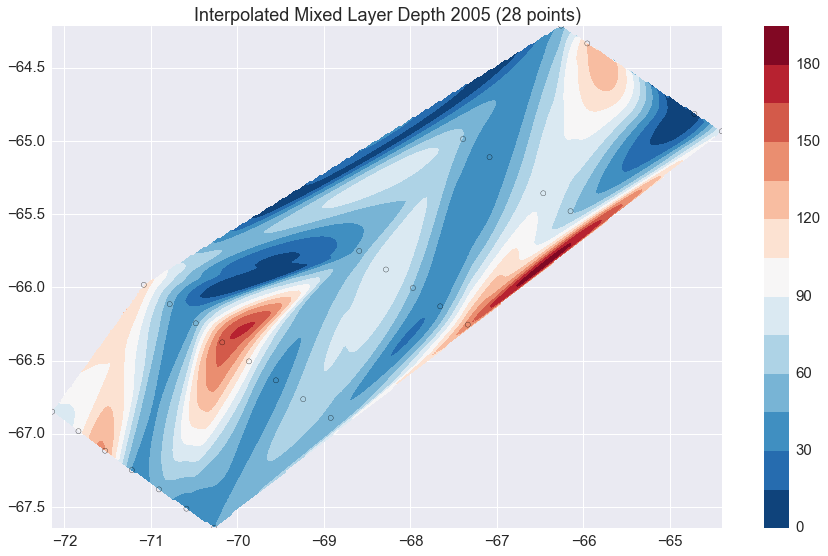

2006


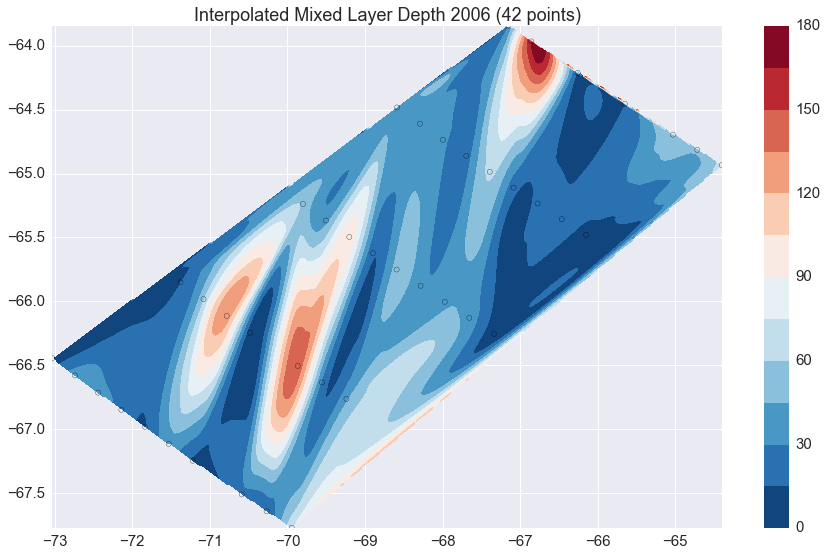

2007


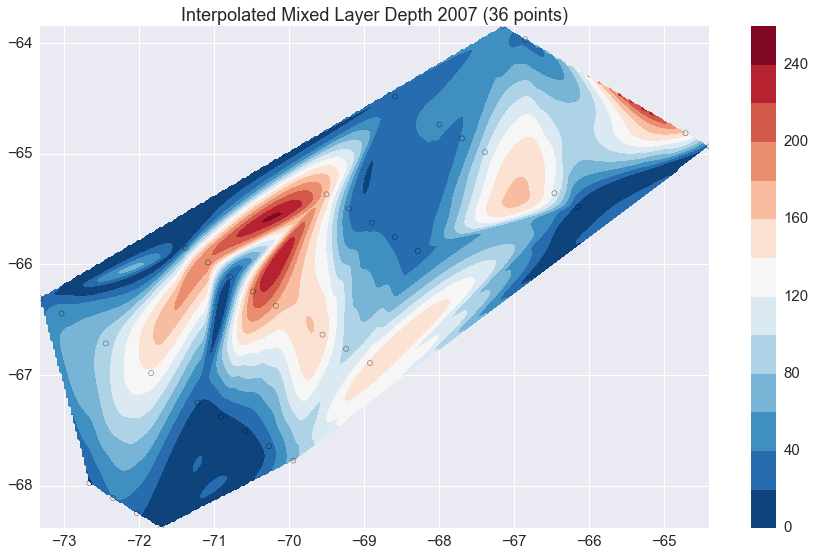

2008


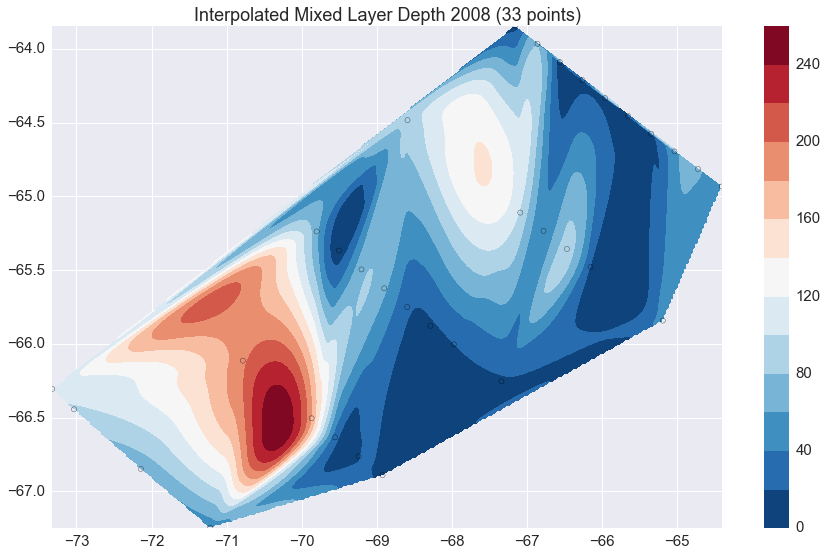

2012


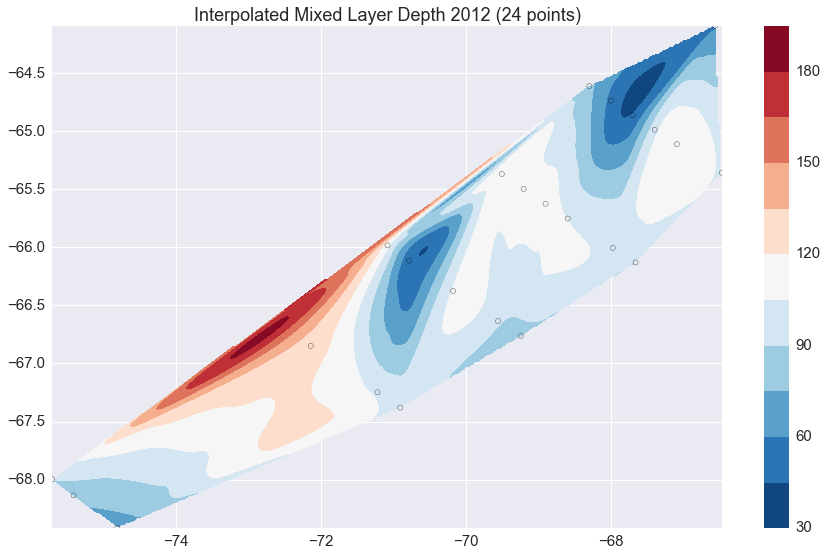

2013


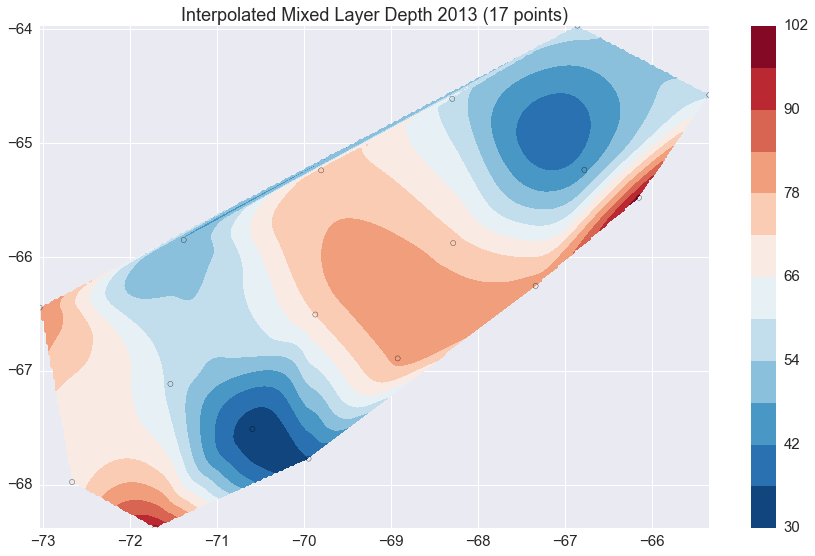

2011


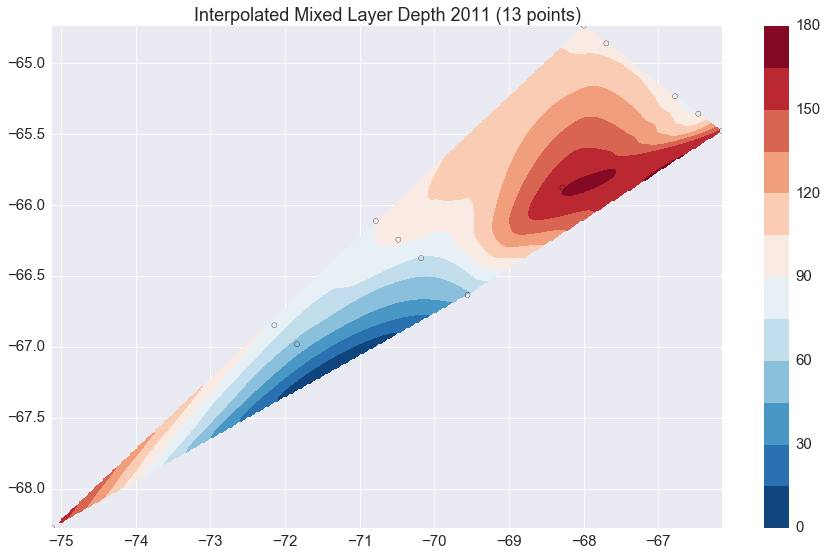

In [94]:
interpolate(df=NOX_df,tracer='NPP')

In [98]:
compile_NPP(method='clustered_MLD',tracer='SiO4',outfile=nppOutfileSiO4)
compile_NPP(method='clustered_MLD',tracer='PO4',outfile=nppOutfilePO4)

SiO4_df = pd.DataFrame(json.loads(open(nppOutfileSiO4,'r').read()))
PO4_df  = pd.DataFrame(json.loads(open(nppOutfilePO4,'r').read()))

SiO4_df= pd.merge(left=SiO4_df,right=newGrid,on='stationID',how='inner')
PO4_df = pd.merge(left=PO4_df,right=newGrid,on='stationID',how='inner')

In [ ]:
# this is a function to test the performance of other functions.
def time_test():
    time1 = 0
    time2 = 0
    for i in range(10000):
        start = time.time()
        func1()
        time1 += time.time()-start
        
        start = time.time()
        func2()
        time2 += time.time()-start
    print("function1",time1/1000,"\nfunction2",time2/1000)
test()

# Interannual Vertical Interpolation Algorithm <a id='slice'></a>
<a href='#h'>Top</a>

In [ ]:
def line_profile(df,chem,maxDepth):
    # Querry the database and clean up
    nutrient  = df.loc[(df[chem]!=skip) & 
                       (df[chem].notnull()) & 
                       (df['stationID'].isin(outOfGrid)==False) &
                       (df['depth']<=maxDepth)]
    
    if(chem=='Nitrite'):
        title = 'NO$_{3}$+NO$_{2}$'
    elif(chem=='PO4'):
        title = 'PO$_{4}$'
    elif(chem=='SiO4'):
        title = 'SiO$_{4}$'
    
    yearList  = nutrient.year.unique()
    yearList.sort()
    # per year
    for year in yearList:
        lineSlice = nutrient[nutrient.year==year]
        lineList = lineSlice.gridLine.unique()

        # per line
        for line in lineList:
            lineSnap = lineSlice.loc[(lineSlice.gridLine==line) &
                                     (lineSlice.depth!=skip)]
            
            x        = lineSnap.gridStation.astype(np.float)
            y        = lineSnap.depth*-1
            z        = lineSnap[chem]
            
            plt.ylabel('Water column height [m]')
            plt.xlabel('Grid Station')

            # If it's not empty let's interpolate!
            if(len(x)>10):
                # define grid.
                xi = np.linspace(x.min(),x.max(),360)
                yi = np.linspace(y.min(),y.max(),360)
                # grid the data.
                zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
                # contour the gridded data.
                CS = plt.contourf(xi,yi,zi,15,cmap=cMap,alpha=1,level=10)
                # plot data points.
                SC = plt.scatter(x,y,c=z,marker='o',s=26,alpha = .8,cmap=cMap)
                cbar = plt.colorbar() # draw colorbar
                plt.xlim(min(x),max(x))
                plt.ylim(min(y),max(y))
                plt.title(title+r' Depth Profile at Line '+str(np.asarray(lineSnap.gridLine)[0])+' '+str(np.asarray(lineSnap.year)[0])+' (%d points)' % len(x))
                plt.gca().invert_xaxis()
                plt.show()

In [ ]:
def interpolate_map(df=inOrg,tracer = 'Nitrite',MLD = False):
    # Querry the database and clean up
    tracer_df  = df.loc[(df[tracer]!=skip) & 
                      (df[tracer].notnull()) & 
                      (df['stationID'].isin(outOfGrid)==False)]

    # choose a title and see if the tracer analysis depth-dependent.
    if(tracer=='Nitrite'):
        title = 'Surface NO$_{3}$+NO$_{2}$'
        tracer_df = tracer_df[tracer_df['depth']<=surfDepth]
    elif(tracer=='PO4'):
        title = 'Surface PO$_{4}$'
        tracer_df = tracer_df[tracer_df['depth']<=surfDepth]
    elif(tracer=='SiO4'):
        title = 'Surface SiO$_{4}$'
        tracer_df = tracer_df[tracer_df['depth']<=surfDepth]
    else:
        title = 'Mixed Layer Depth'
        tracer_df = tracer_df.loc[(tracer_df[tracer]<200) & (tracer_df[tracer]>0)]

    # Interpolate and plot for each year
    for year in pd.unique(tracer_df.year.values.ravel()):
        map = Basemap(width=1000000,height=640000,
                    resolution='l',projection='stere',\
                    lat_ts=50,lat_0=-66.40,lon_0=-69.05)
        map.drawparallels(np.arange(-90.,90.,1.),labels=[False,False,False,True],
                          color='w',dashes=[100,.0001],zorder=0)
        map.drawmeridians(np.arange(-180.,181.,1.),labels=[True,False,False,False],
                          color='w',dashes=[100,.0001],zorder=0)
        map.drawcoastlines()
        map.fillcontinents()
        map.drawmapboundary()
        querry  = tracer_df[tracer_df['year']==year]
        # Define the plotable elements
        x = querry.lon.values
        y = querry.lat.values
        z = querry[tracer].values
        labels = querry.stationID
        xM,yM = map(x, y)
        # If it's not empty let's interpolate!
        if(len(x)>10):
            # plot data points.
            map.scatter(xM,yM,facecolors='none', edgecolors='k',s=26, zorder=2)
            gridBounds = ['000.220','100.220','200.220','300.220','400.220','500.220','600.220']
            gridLabels = newGrid[newGrid['stationID'].isin(gridBounds)]
            x3 = gridLabels.lon.values
            y3 = gridLabels.lat.values
            xS, yS = map(x3, y3)
            labels = gridLabels.gridLine.values.astype(int)
            for label, xpt, ypt in zip(labels, xS, yS):
                plt.text(xpt-60000, ypt+12000, label,size=14)
            if(MLD==True):
                querr2  = mld_df[mld_df['year']==year]
                x1 = querr2.lon.values
                y1 = querr2.lat.values
                xM1,yM1 = map(x1,y1)
                map.scatter(xM1,yM1, color='orange',s=26,zorder = 1)
            else:
                # define grid.
                xi = np.linspace(xM.min(),xM.max(),300)
                yi = np.linspace(yM.min(),yM.max(),300)
                # grid the data.
                zi = abs(griddata((xM, yM), z, (xi[None,:], yi[:,None]), method='cubic'))
                # contour the gridded data.
                plt.contourf(xi,yi,zi,12,cmap=cMap)
                plt.colorbar() # draw colorbar
            plt.title('Interpolated '+title+' '+str(np.asarray(querry.year)[0])+' (%d points)' % len(x))
            plt.show()